# Iterations

## Iteration 1

### Utils

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, precision_recall_curve, average_precision_score, f1_score
from sklearn.preprocessing import label_binarize

class CombinedHistory:
    def __init__(self, combined_history_dict):
        self.history = combined_history_dict

def combine_histories(histories):
    combined_history = {}
    for key in histories[0].history.keys():
        combined_history[key] = []
        for history in histories:
            combined_history[key].extend(history.history[key])
    return CombinedHistory(combined_history)

# Define the function to plot all metrics including balanced accuracy
def show_all_plots(histories, model, validation_generator):


    if isinstance(histories, list):  # Check if it's a list of histories
        history = combine_histories(histories)
    else:  # If single history is passed, use it directly
        history = histories
    


    # Assuming `validation_generator` has class indices mapped to class names
    class_names = list(validation_generator.class_indices.keys())

    # Calculate balanced accuracy for each epoch

    # Get true labels and predictions for the entire validation set
    y_true = []
    y_pred = []

    for i in range(len(validation_generator)):
        X_val_batch, y_val_batch = validation_generator[i]
        y_pred_batch = model.predict(X_val_batch, verbose=0)
        y_pred.extend(y_pred_batch)  # Keep the raw probabilities for precision-recall
        y_true.extend(y_val_batch)   # Keep the one-hot encoded true labels

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate balanced accuracy, confusion matrix, and F1 score
    y_true_labels = np.argmax(y_true, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    balanced_acc = balanced_accuracy_score(y_true_labels, y_pred_labels)
    conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True) * 100


    # Print metrics
    print(f"Balanced Accuracy: {balanced_acc}")
    print(f"Accuracy on test set: {model.evaluate(validation_generator, verbose=0)[1]}")
    print(f"F1 Score: {f1_score(y_true_labels, y_pred_labels, average='weighted')}")

    # Set up a 2x2 grid for the plots
    plt.figure(figsize=(16,14), constrained_layout=True)
    
    # 1. Accuracy plot
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # 2. Loss plot
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # 3. Confusion matrix plot
    plt.subplot(2, 2, 3)
    sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # 4. Precision-Recall Curve plot
    plt.subplot(2, 2, 4)
    show_precision_recall(y_true, y_pred)

    # Show all the plots
    plt.show()

def show_precision_recall(y_test, predictions):
    class_names = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC']
    
    # Binarize the output for multiclass
    y_test = label_binarize(y_test, classes=range(len(class_names)))
    predictions = np.array(predictions)

    precision = dict()
    recall = dict()
    average_precision = dict()
    
    # Compute Precision-Recall and average precision for each class
    for i in range(len(class_names)):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], predictions[:, i])
        average_precision[i] = average_precision_score(y_test[:, i], predictions[:, i])

    # Compute micro-average Precision-Recall curve and area
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(), predictions.ravel())
    average_precision["micro"] = average_precision_score(y_test, predictions, average="micro")
    
    # Plot Precision-Recall curve
    plt.plot(recall["micro"], precision["micro"], color='gold', lw=2, label=f'Micro-average (area = {average_precision["micro"]:0.2f})')
    for i, color in enumerate(['blue', 'green', 'red', 'purple', 'brown', 'cyan', 'magenta']):
        plt.plot(recall[i], precision[i], color=color, lw=2, label=f'Class {class_names[i]} (area = {average_precision[i]:0.2f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc='best')


### Training

In [2]:
train_dir = "Data Set Ordered/training data/"
val_dir = "Data Set Ordered/validation data/"
test_dir = "Data Set Ordered/test data/"
model_dir = "models/best_model_iteration_1/"

In [3]:
from keras.applications import MobileNetV3Small
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import SGD
from keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
)


# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    val_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

# Validation generator
test_generator = train_datagen.flow_from_directory(
    test_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
      layer.trainable = False

  # Add custom layers for classification
x = base_model.output
x = Flatten()(x)
preds = Dense(7,activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=preds)

sgd = SGD()

# Compile model - make it trainable
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])



/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Found 10015 images belonging to 7 classes.
Found 193 images belonging to 7 classes.
Found 1512 images belonging to 7 classes.


In [4]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=model_dir,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',  
    patience=15,          
    min_delta=0.001      
)

# Train the model with the callback
history2 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    verbose=1,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 7.4657 - accuracy: 0.6788
Epoch 1: val_loss improved from inf to 4.40595, saving model to models/best_model_iteration_1/
INFO:tensorflow:Assets written to: models/best_model_iteration_1/assets


INFO:tensorflow:Assets written to: models/best_model_iteration_1/assets


313/313 [==============================] - 37s 115ms/step - loss: 7.4657 - accuracy: 0.6788 - val_loss: 4.4060 - val_accuracy: 0.7358
Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 4.4074 - accuracy: 0.7624
Epoch 2: val_loss did not improve from 4.40595
313/313 [==============================] - 32s 100ms/step - loss: 4.4074 - accuracy: 0.7624 - val_loss: 7.3626 - val_accuracy: 0.7202
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 2.8403 - accuracy: 0.8191
Epoch 3: val_loss improved from 4.40595 to 3.18480, saving model to models/best_model_iteration_1/
INFO:tensorflow:Assets written to: models/best_model_iteration_1/assets


INFO:tensorflow:Assets written to: models/best_model_iteration_1/assets


313/313 [==============================] - 36s 114ms/step - loss: 2.8403 - accuracy: 0.8191 - val_loss: 3.1848 - val_accuracy: 0.7720
Epoch 4/50
313/313 [==============================] - ETA: 0s - loss: 2.2343 - accuracy: 0.8465
Epoch 4: val_loss improved from 3.18480 to 2.57251, saving model to models/best_model_iteration_1/
INFO:tensorflow:Assets written to: models/best_model_iteration_1/assets


INFO:tensorflow:Assets written to: models/best_model_iteration_1/assets


313/313 [==============================] - 36s 114ms/step - loss: 2.2343 - accuracy: 0.8465 - val_loss: 2.5725 - val_accuracy: 0.7876
Epoch 5/50
313/313 [==============================] - ETA: 0s - loss: 1.4887 - accuracy: 0.8784
Epoch 5: val_loss improved from 2.57251 to 2.47885, saving model to models/best_model_iteration_1/
INFO:tensorflow:Assets written to: models/best_model_iteration_1/assets


INFO:tensorflow:Assets written to: models/best_model_iteration_1/assets


313/313 [==============================] - 36s 116ms/step - loss: 1.4887 - accuracy: 0.8784 - val_loss: 2.4789 - val_accuracy: 0.7513
Epoch 6/50
313/313 [==============================] - ETA: 0s - loss: 1.1559 - accuracy: 0.9019
Epoch 6: val_loss did not improve from 2.47885
313/313 [==============================] - 31s 98ms/step - loss: 1.1559 - accuracy: 0.9019 - val_loss: 6.7119 - val_accuracy: 0.6218
Epoch 7/50
313/313 [==============================] - ETA: 0s - loss: 0.9795 - accuracy: 0.9143
Epoch 7: val_loss improved from 2.47885 to 2.30465, saving model to models/best_model_iteration_1/
INFO:tensorflow:Assets written to: models/best_model_iteration_1/assets


INFO:tensorflow:Assets written to: models/best_model_iteration_1/assets


313/313 [==============================] - 37s 119ms/step - loss: 0.9795 - accuracy: 0.9143 - val_loss: 2.3046 - val_accuracy: 0.7772
Epoch 8/50
313/313 [==============================] - ETA: 0s - loss: 0.7012 - accuracy: 0.9328
Epoch 8: val_loss did not improve from 2.30465
313/313 [==============================] - 34s 109ms/step - loss: 0.7012 - accuracy: 0.9328 - val_loss: 2.6056 - val_accuracy: 0.7979
Epoch 9/50
313/313 [==============================] - ETA: 0s - loss: 0.5994 - accuracy: 0.9362
Epoch 9: val_loss did not improve from 2.30465
313/313 [==============================] - 33s 104ms/step - loss: 0.5994 - accuracy: 0.9362 - val_loss: 2.4719 - val_accuracy: 0.7876
Epoch 10/50
313/313 [==============================] - ETA: 0s - loss: 0.4384 - accuracy: 0.9506
Epoch 10: val_loss did not improve from 2.30465
313/313 [==============================] - 33s 106ms/step - loss: 0.4384 - accuracy: 0.9506 - val_loss: 2.4121 - val_accuracy: 0.7876
Epoch 11/50
313/313 [============

INFO:tensorflow:Assets written to: models/best_model_iteration_1/assets


313/313 [==============================] - 40s 128ms/step - loss: 0.3444 - accuracy: 0.9594 - val_loss: 2.2716 - val_accuracy: 0.7876
Epoch 12/50
313/313 [==============================] - ETA: 0s - loss: 0.1732 - accuracy: 0.9733
Epoch 12: val_loss improved from 2.27158 to 1.92601, saving model to models/best_model_iteration_1/
INFO:tensorflow:Assets written to: models/best_model_iteration_1/assets


INFO:tensorflow:Assets written to: models/best_model_iteration_1/assets


313/313 [==============================] - 40s 127ms/step - loss: 0.1732 - accuracy: 0.9733 - val_loss: 1.9260 - val_accuracy: 0.7979
Epoch 13/50
313/313 [==============================] - ETA: 0s - loss: 0.1139 - accuracy: 0.9795
Epoch 13: val_loss did not improve from 1.92601
313/313 [==============================] - 36s 114ms/step - loss: 0.1139 - accuracy: 0.9795 - val_loss: 2.4191 - val_accuracy: 0.7720
Epoch 14/50
313/313 [==============================] - ETA: 0s - loss: 0.0632 - accuracy: 0.9878
Epoch 14: val_loss improved from 1.92601 to 1.92513, saving model to models/best_model_iteration_1/
INFO:tensorflow:Assets written to: models/best_model_iteration_1/assets


INFO:tensorflow:Assets written to: models/best_model_iteration_1/assets


313/313 [==============================] - 40s 129ms/step - loss: 0.0632 - accuracy: 0.9878 - val_loss: 1.9251 - val_accuracy: 0.8083
Epoch 15/50
313/313 [==============================] - ETA: 0s - loss: 0.1077 - accuracy: 0.9819
Epoch 15: val_loss did not improve from 1.92513
313/313 [==============================] - 40s 126ms/step - loss: 0.1077 - accuracy: 0.9819 - val_loss: 2.2377 - val_accuracy: 0.7876
Epoch 16/50
313/313 [==============================] - ETA: 0s - loss: 0.0316 - accuracy: 0.9917
Epoch 16: val_loss did not improve from 1.92513
313/313 [==============================] - 32s 101ms/step - loss: 0.0316 - accuracy: 0.9917 - val_loss: 2.3424 - val_accuracy: 0.7565
Epoch 17/50
313/313 [==============================] - ETA: 0s - loss: 0.0289 - accuracy: 0.9917
Epoch 17: val_loss did not improve from 1.92513
313/313 [==============================] - 32s 101ms/step - loss: 0.0289 - accuracy: 0.9917 - val_loss: 2.0283 - val_accuracy: 0.7876
Epoch 18/50
313/313 [========

Balanced Accuracy: 0.4540413466192089
Accuracy on test set: 0.7103174328804016
F1 Score: 0.697048941390215


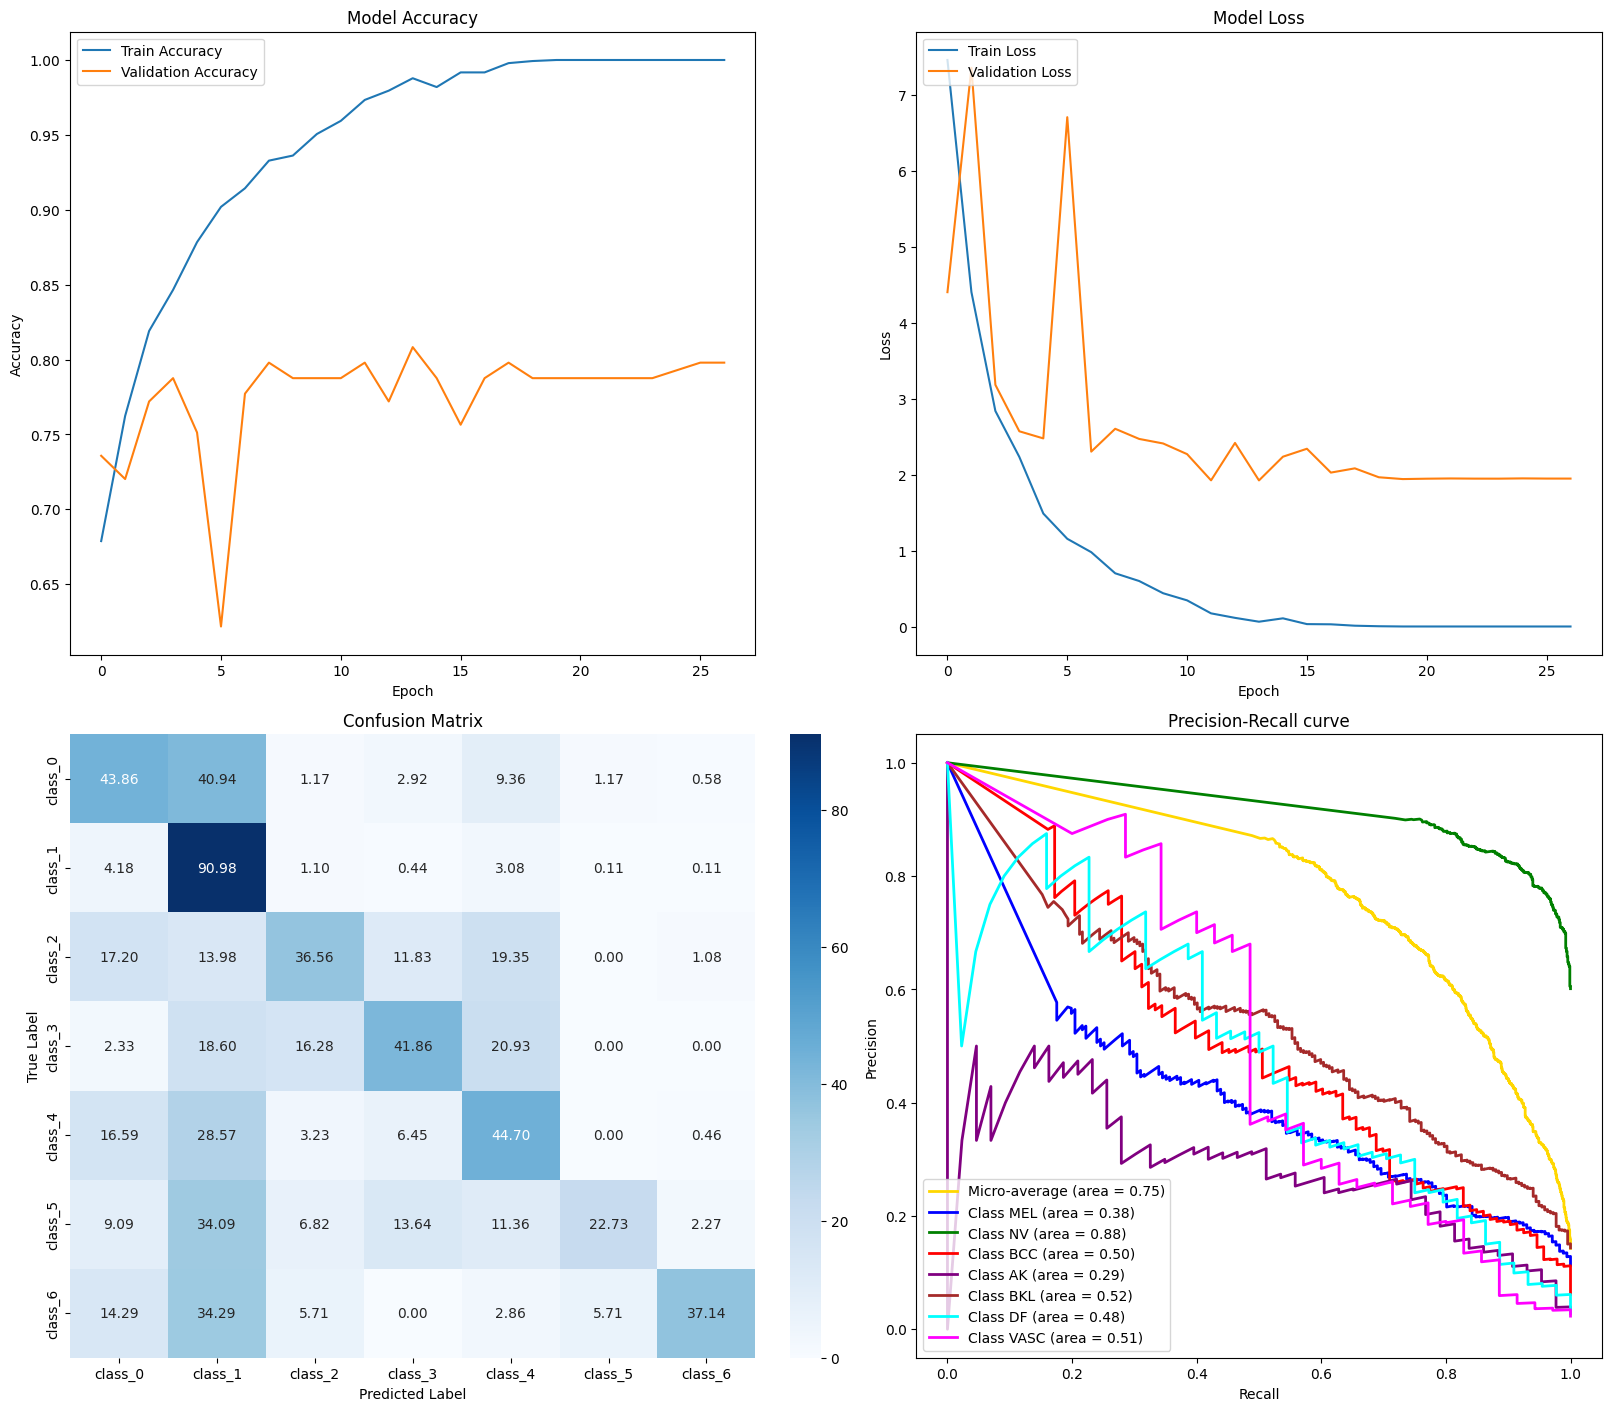

In [7]:
from tensorflow.keras.models import load_model


model = load_model(model_dir)

show_all_plots(history2, model, test_generator)

### What did we learn????

- Overfitting:
    - yes
- Efficiency:
    - Super fint - den er hurtig (30 sec per epoch - 100=51 min)
- Performance:
    - Accuracy -> train=100, val=77.72, test: 70.42
    - loss -> train=fuckinglav, val=1.84854, test=4.7873

Takaways:
- We did not expect it to learn to differentiate between the 7 classes as they are very unbalanced.
- We did not expect it to learn this much
- It doesnt learn that well for val/test and there is a large gap between train and the others

What to do next time?
- Experiment with Learning Rate
    - we can observe that model has "plateaued", meaning that the validation loss neither goes up or down, 
    with the use of a Learning Rate Scheduler we could force the model out of the plateau and maybe achieve a lower loss (maybe?).
    - week 6 slide11
- Experiment with Regularization 
    - we can observe that there is a significant difference between the loss in train and val. This can be tackle by implementing regularization techniques.
        - Data augmentation
        - Early Stopping! (always do this)
        - Dropout
        - Add Noise when training

## Iteration 2

Here we test our new own dataloader where we make a own split of all data given.
- The dataloader just splits the dataset - everything else should work as keras imagedatagenerator

### Utils

In [9]:
import os
import random
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence, to_categorical
from itertools import chain

class Dataloader(Sequence):
    def __init__(self, data, batch_size, image_size, is_validation=False, preprocess_function=None, class_distribuition=[], class_names=[]):
        #self.data_dir = data_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.isValidation = is_validation
        self.class_distribution = class_distribuition if not is_validation else []
        self.preprocess_function = preprocess_function


        self.class_names = class_names
        self.num_classes = len(self.class_names)
        self.class_to_label = {class_name: i for i, class_name in enumerate(self.class_names)} # mapping {'class1': 0, 'class2': 1, ...})

        self.image_paths, self.labels = zip(*data)
        self.image_paths = list(self.image_paths)  # Convert from tuple to list
        self.labels = list(self.labels)           # Convert from tuple to list

        self.indexes_for_class = [[] for _ in range(self.num_classes)]

        self.all_image_indices = self._create_indices_distr() if not self.isValidation else list(range(len(self.image_paths)))
        self.samples = len(self.all_image_indices)
        #self._shuffle_indices()
        print(f"Found {len(self.image_paths)} images belonging to {self.num_classes} classes (dist says {sum(self.class_distribution)})")
        self._shuffle_indices()


    def _create_indices_distr(self):
        for index, label in enumerate(self.labels):
            self.indexes_for_class[label].append(index) # I assume its list 4 has all the indexes for label class_5

        res = list(chain.from_iterable(self.indexes_for_class)) # flattens the list-of-lists to one list
        return res



    def _load_data(self):
        image_paths = []
        labels = []
        for class_name in self.class_names:
            class_dir = os.path.join(self.data_dir, class_name)
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                image_paths.append(image_path)
                labels.append(self.class_to_label[class_name])

        #print(f"Found {len(image_paths)} images belonging to {self.num_classes} classes (dist says {sum(self.class_distribution)})")
        return image_paths, labels

    def _preprocess_image(self, image_path):
        img = load_img(image_path, target_size=self.image_size)
        x = img_to_array(img)


        if self.preprocess_function:
            x = self.preprocess_function(x)
        return x

    def _shuffle_indices(self):
        random.shuffle(self.all_image_indices)


    def __len__(self):
        num_samples = len(self.all_image_indices) # no_images=100 batchsize=20, then 100/20=5 number of iterations to get through the whole dataset
        return num_samples // self.batch_size
    
    def __getitem__(self, index):
        start = index * self.batch_size
        end = start + self.batch_size
        images = []
        labels = []

        batch_image_indices = self.all_image_indices[start:end]

        for image_index in batch_image_indices:
            image_path = self.image_paths[image_index]
            image = self._preprocess_image(image_path)
            images.append(image)
            labels.append(to_categorical(self.labels[image_index], num_classes=self.num_classes))

        return np.array(images), np.array(labels)

    def on_epoch_end(self):
        if not self.isValidation:
            self._shuffle_indices()



import os
import json
from sklearn.model_selection import train_test_split

class DataloaderFactory():
    def __init__(self, dir, image_size, batch_size, set_distribution, class_distribution=[], preprocess_function=None, split_file="data_split.json"):
        self.dir = dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.set_distribution = set_distribution
        self.class_distribution = class_distribution
        self.preprocess_function = preprocess_function
        self.split_file = split_file
        self.class_names = []

    def _load_data(self):
        """Load images and labels as tuples (path, label)."""
        data = []
        self.class_names = sorted(os.listdir(self.dir))
        for label, class_name in enumerate(self.class_names):
            class_dir = os.path.join(self.dir, class_name)
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                data.append((image_path, label))  # Append (path, label) as a tuple
        return data

    def _split_data(self, data):
        """Split data into train, validation, and test sets based on the specified distribution."""
        # Check if the split file exists
        if os.path.exists(self.split_file):
            print(f"Loading data split from {self.split_file}")
            with open(self.split_file, "r") as f:
                return json.load(f)

        print("Splitting data...")
        indices = list(range(len(data)))
        _, val_ratio, test_ratio = [p / 100 for p in self.set_distribution]

        labels = [label for _, label in data]
        train_idxs, test_idxs, _, _ = train_test_split(
            indices, labels, test_size=(val_ratio + test_ratio), stratify=labels
        )
        val_split = val_ratio / (val_ratio + test_ratio)
        val_idxs, test_idxs = train_test_split(
            test_idxs, test_size=(1 - val_split), stratify=[labels[i] for i in test_idxs]
        )

        split = {"train": train_idxs, "val": val_idxs, "test": test_idxs}

        # Save the split to a file
        with open(self.split_file, "w") as f:
            json.dump(split, f)
        print(f"Data split saved to {self.split_file}")

        return split

    def get_dataloaders(self):
        """Generate dataloaders for training, validation, and testing."""
        data = self._load_data()  # List of (path, label) tuples
        data_splits = self._split_data(data)  # Split data by indices
        loaders = {}

        for split, indexes in data_splits.items():
            preprocess_func = self.preprocess_function if split == "train" else None
            split_data = [data[i] for i in indexes]  # Subset the data using indices
            loaders[split] = Dataloader(
                data=split_data,  # Pass the list of tuples
                batch_size=self.batch_size,
                image_size=self.image_size,
                is_validation=(split != "train"),
                preprocess_function=preprocess_func,
                class_distribuition=self.class_distribution,
                class_names=self.class_names
            )

        return loaders["train"], loaders["val"], loaders["test"]


### Training

In [14]:
data_dir = "Merge Set Ordered"
iteration = "iteration_2"
model_dir = f'models/best_model_{iteration}.h5'

In [15]:

from keras.applications.mobilenet_v3 import preprocess_input

batch_size=32
dist = []
histories = []

factory = DataloaderFactory(data_dir, batch_size=batch_size, image_size=(224,224), set_distribution=(70,15,15), class_distribution=dist, preprocess_function=preprocess_input)

train_generator, validation_generator, test_generator = factory.get_dataloaders()

Splitting data...
Data split saved to data_split.json
Found 8202 images belonging to 7 classes (dist says 0)
Found 1758 images belonging to 7 classes (dist says 0)
Found 1758 images belonging to 7 classes (dist says 0)


In [16]:
from keras.applications import MobileNetV3Small
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import SGD

base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
      layer.trainable = False

  # Add custom layers for classification
x = base_model.output
x = Flatten()(x)
preds = Dense(7,activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=preds)

sgd = SGD()

# Compile model - make it trainable
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [17]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=model_dir,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',  
    patience=15,          
    min_delta=0.001      
)

# Train the model with the callback
history2 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    verbose=1,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/30
256/256 [==============================] - ETA: 0s - loss: 9.1167 - accuracy: 0.6505
Epoch 1: val_loss improved from inf to 3.99725, saving model to models/best_model_iteration_2.h5
256/256 [==============================] - 32s 120ms/step - loss: 9.1167 - accuracy: 0.6505 - val_loss: 3.9973 - val_accuracy: 0.7072
Epoch 2/30


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


256/256 [==============================] - ETA: 0s - loss: 4.4007 - accuracy: 0.7581
Epoch 2: val_loss did not improve from 3.99725
256/256 [==============================] - 29s 111ms/step - loss: 4.4007 - accuracy: 0.7581 - val_loss: 4.3445 - val_accuracy: 0.7326
Epoch 3/30
256/256 [==============================] - ETA: 0s - loss: 3.2718 - accuracy: 0.8020
Epoch 3: val_loss did not improve from 3.99725
256/256 [==============================] - 28s 110ms/step - loss: 3.2718 - accuracy: 0.8020 - val_loss: 7.1638 - val_accuracy: 0.7425
Epoch 4/30
256/256 [==============================] - ETA: 0s - loss: 2.2475 - accuracy: 0.8440
Epoch 4: val_loss did not improve from 3.99725
256/256 [==============================] - 29s 112ms/step - loss: 2.2475 - accuracy: 0.8440 - val_loss: 4.5050 - val_accuracy: 0.7720
Epoch 5/30
256/256 [==============================] - ETA: 0s - loss: 1.5759 - accuracy: 0.8721
Epoch 5: val_loss improved from 3.99725 to 3.72166, saving model to models/best_mode

['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6']
Balanced Accuracy: 0.6239402892444199
Accuracy on test set: 0.7928240895271301
F1 Score: 0.7913760177353695


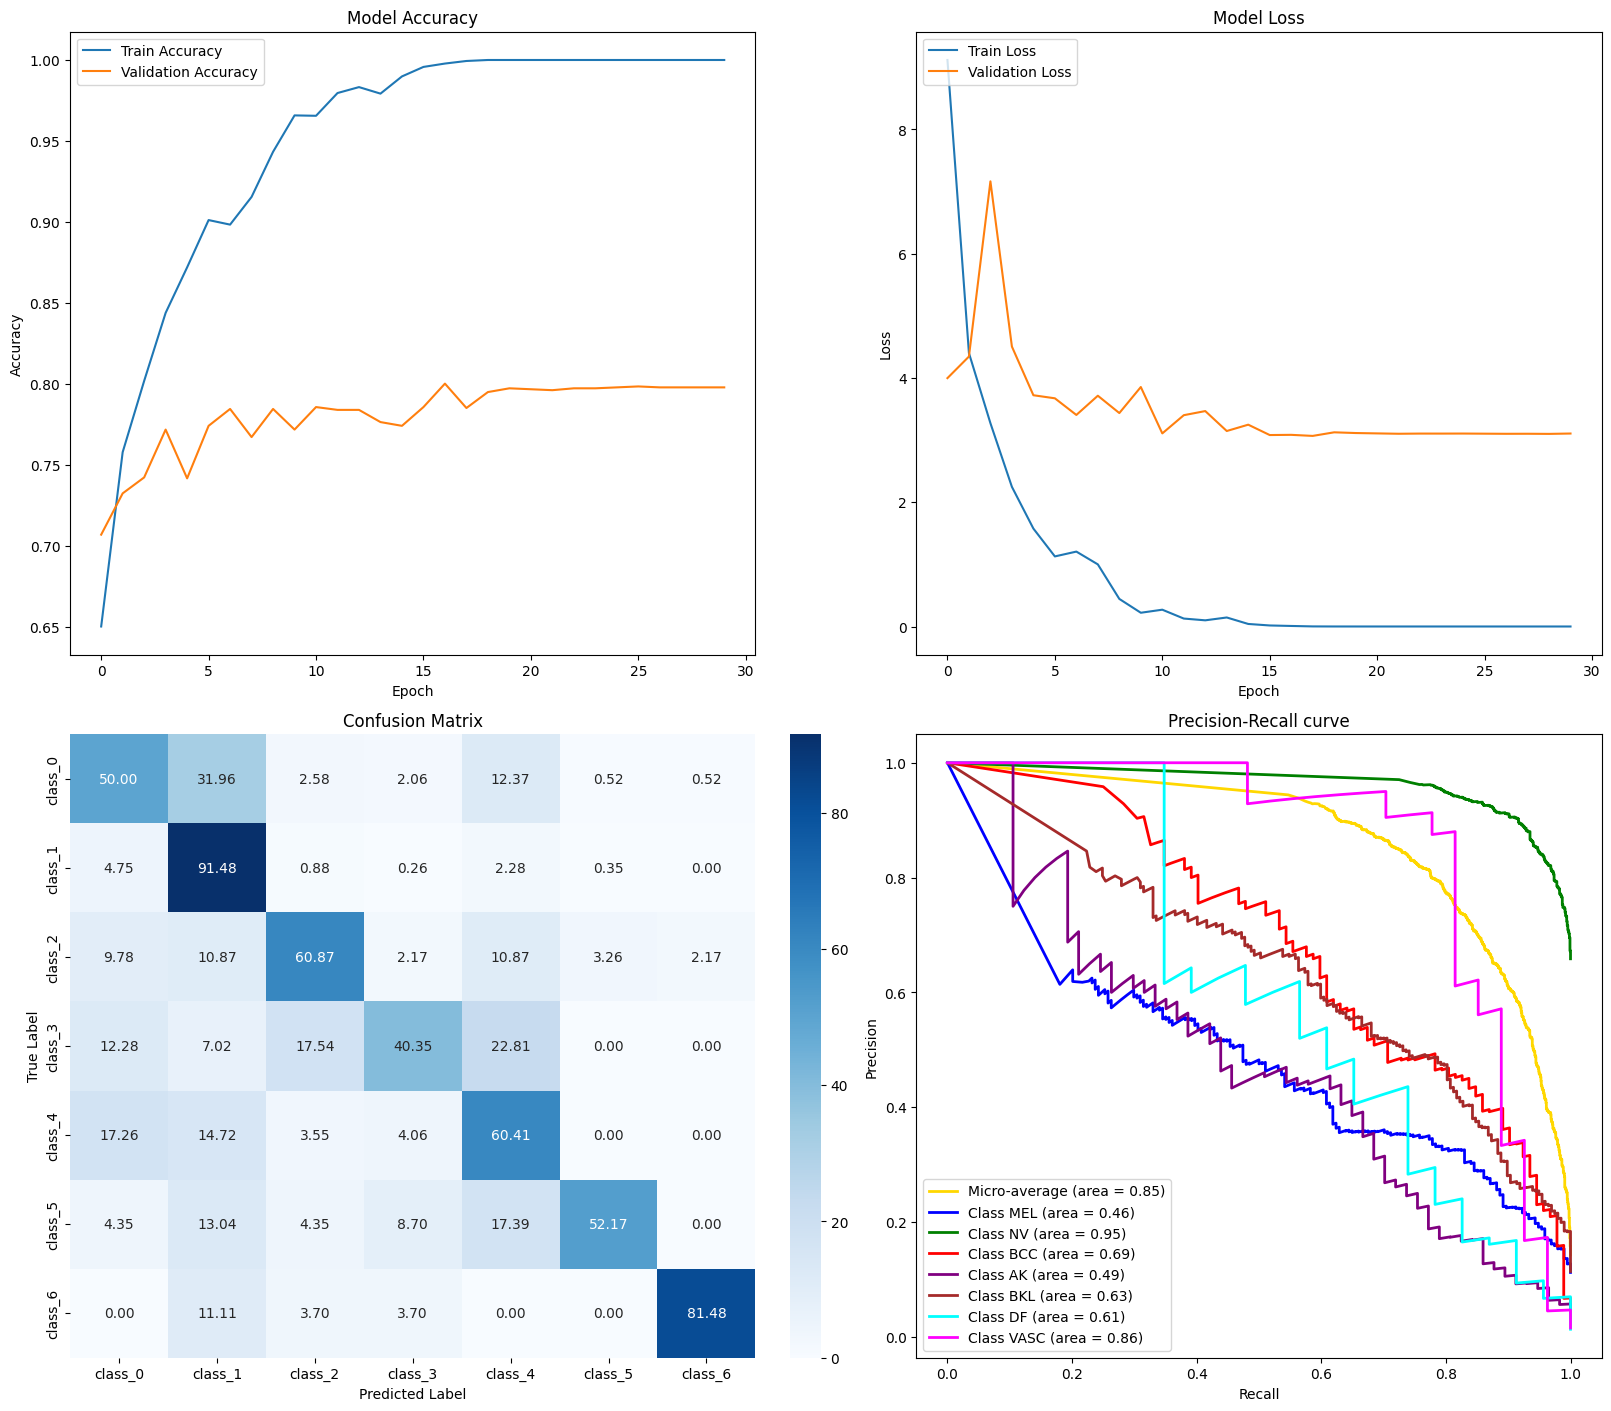

In [20]:
from tensorflow.keras.models import load_model
from plot_utils import show_all_plots

model = load_model(model_dir)

show_all_plots([history2], model, test_generator)

## Iteration 3

Here we try to improve on the confusion. It seems that the model cant handle the unbalanced nature of the dataset. 
We tackle this by:
1. making sure that each class is equally represented in each batch (undersampling to the lowest represented class)
2. making sure that each class is equally represented in each batch (over/undersampling with augmentations to oversample)
3. using class weights 

### Training 1

In [41]:
data_dir = "Merge Set Ordered"
iteration = "iteration_3_1"
model_dir = f'models/best_model_{iteration}.h5'

In [42]:
from keras.applications.mobilenet_v3 import preprocess_input


# Now import HomemadeDataloader from homemade_dataloader.py
from homemade_dataloader import DataloaderFactory


batch_size=32
dist = [115,115,115,115,115,115,115]
print(sum(dist))

factory = DataloaderFactory(data_dir, batch_size=batch_size, image_size=(224,224), set_distribution=(70,15,15), class_distribution=dist, preprocess_function=preprocess_input)

train_generator, validation_generator, test_generator = factory.get_dataloaders()

805
Loading data split from data_split.json
Found 8202 images belonging to 7 classes (dist says 805)
Found 1758 images belonging to 7 classes (dist says 0)
Found 1758 images belonging to 7 classes (dist says 0)


In [43]:
from keras.applications import MobileNetV3Small
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import SGD

base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
      layer.trainable = False

  # Add custom layers for classification
x = base_model.output
x = Flatten()(x)
preds = Dense(7,activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=preds)

sgd = SGD()

# Compile model - make it trainable
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [44]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=model_dir,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',  
    patience=15,          
    min_delta=0.001      
)

# Train the model with the callback
history3_1 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    verbose=1,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/30
25/25 [==============================] - ETA: 0s - loss: 18.3875 - accuracy: 0.3013
Epoch 1: val_loss improved from inf to 4.98667, saving model to models/best_model_iteration_3_1.h5
25/25 [==============================] - 12s 440ms/step - loss: 18.3875 - accuracy: 0.3013 - val_loss: 4.9867 - val_accuracy: 0.5868
Epoch 2/30


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 12.1295 - accuracy: 0.4225
Epoch 2: val_loss did not improve from 4.98667
25/25 [==============================] - 11s 435ms/step - loss: 12.1295 - accuracy: 0.4225 - val_loss: 8.2518 - val_accuracy: 0.5318
Epoch 3/30
25/25 [==============================] - ETA: 0s - loss: 9.7674 - accuracy: 0.4688
Epoch 3: val_loss did not improve from 4.98667
25/25 [==============================] - 11s 426ms/step - loss: 9.7674 - accuracy: 0.4688 - val_loss: 13.5089 - val_accuracy: 0.3206
Epoch 4/30
25/25 [==============================] - ETA: 0s - loss: 10.6950 - accuracy: 0.4625
Epoch 4: val_loss did not improve from 4.98667
25/25 [==============================] - 11s 425ms/step - loss: 10.6950 - accuracy: 0.4625 - val_loss: 7.8387 - val_accuracy: 0.5758
Epoch 5/30
25/25 [==============================] - ETA: 0s - loss: 9.5084 - accuracy: 0.4975
Epoch 5: val_loss did not improve from 4.98667
25/25 [==============================] - 11s 4

['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6']
Balanced Accuracy: 0.6139316643250936
Accuracy on test set: 0.6898148059844971
F1 Score: 0.7072219390709129


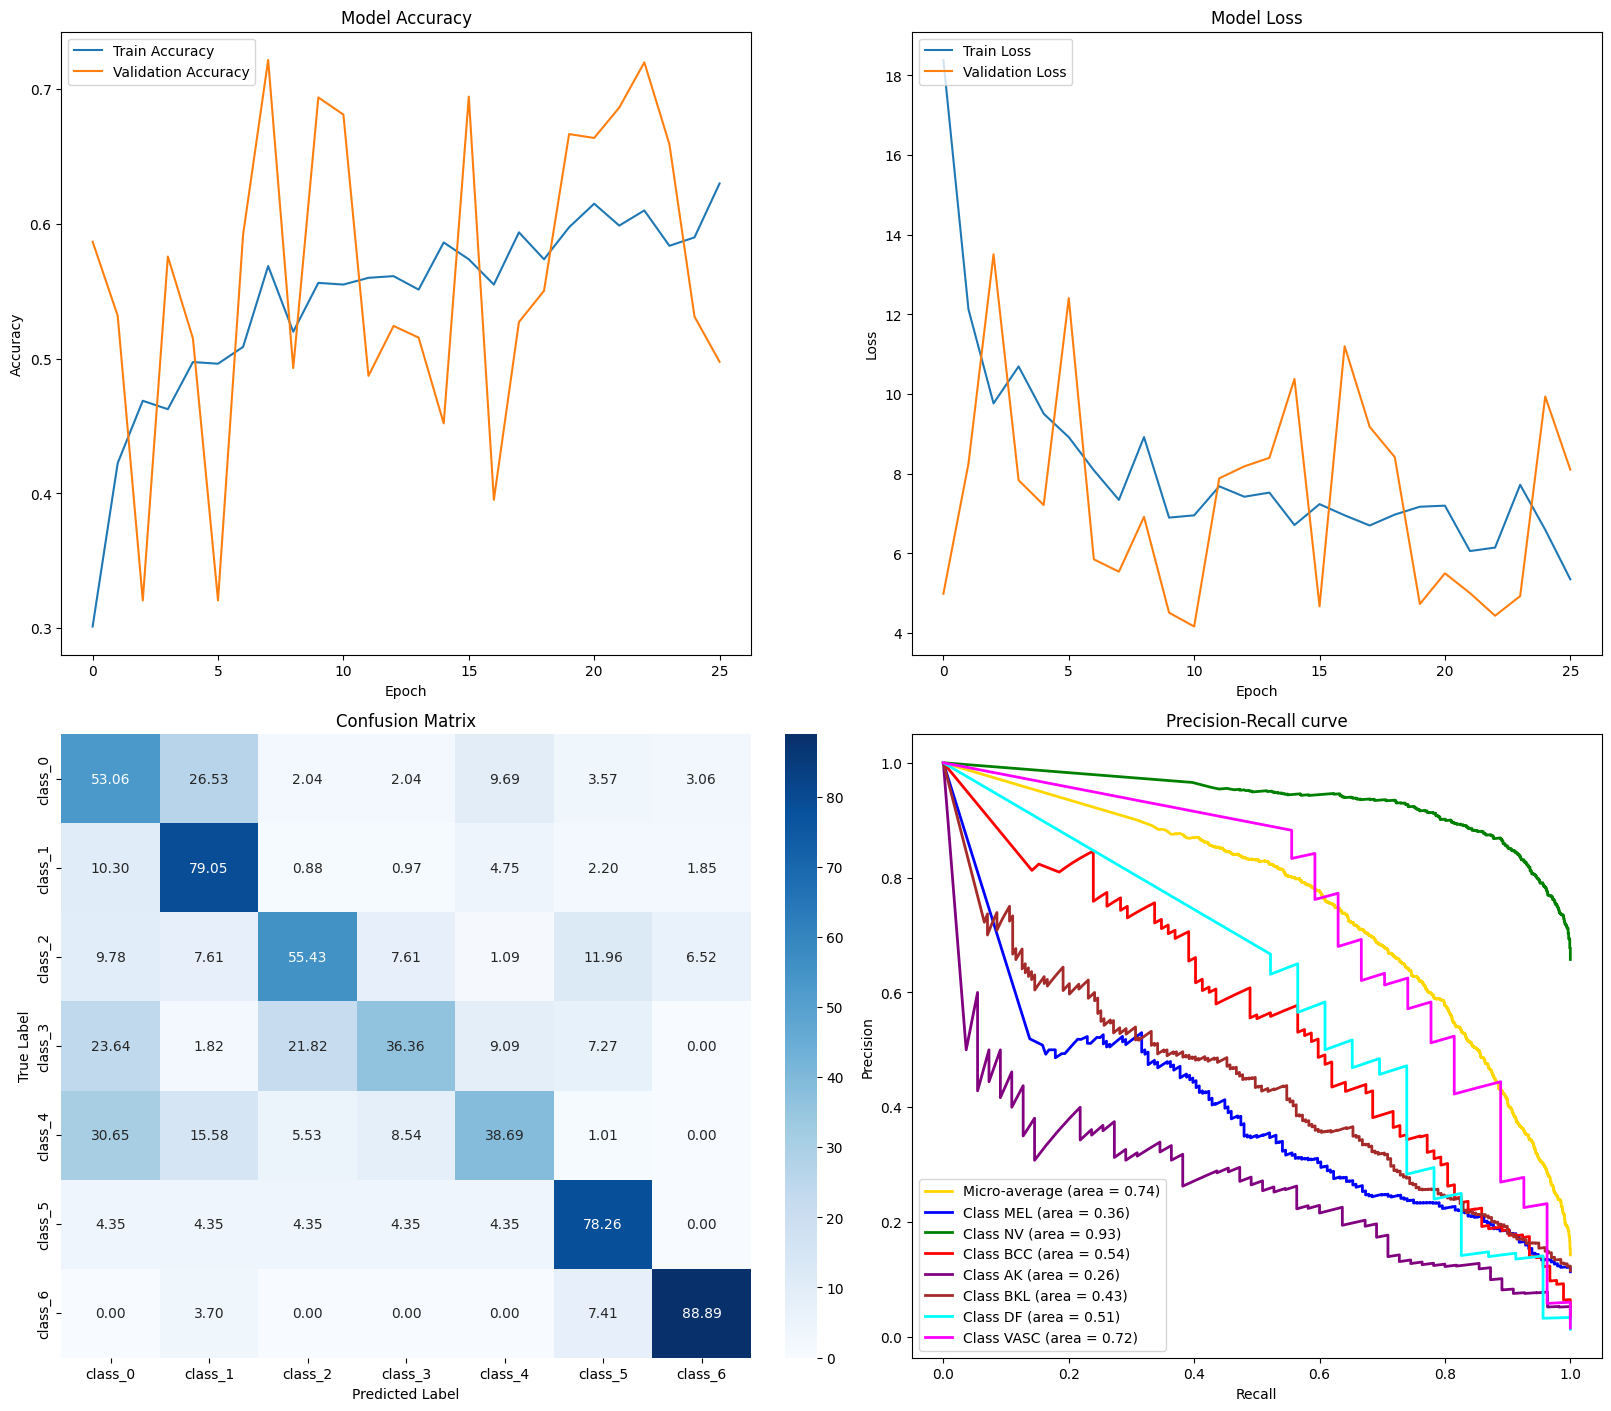

In [45]:
from tensorflow.keras.models import load_model
from plot_utils import show_all_plots

model = load_model(model_dir)

show_all_plots([history3_1], model, test_generator)

### Training 2

In [36]:
data_dir = "Merge Set Ordered"
iteration = "iteration_3_2"
model_dir = f'models/best_model_{iteration}.h5'

In [37]:
from keras.applications.mobilenet_v3 import preprocess_input

# Now import HomemadeDataloader from homemade_dataloader.py
from homemade_dataloader import DataloaderFactory


batch_size=32
dist = [1171,1171,1171,1171,1171,1171,1171]
print(sum(dist))
histories = []

factory = DataloaderFactory(data_dir, batch_size=batch_size, image_size=(224,224), set_distribution=(70,15,15), class_distribution=dist, preprocess_function=preprocess_input)

train_generator, validation_generator, test_generator = factory.get_dataloaders()

8197
Loading data split from data_split.json
Found 8202 images belonging to 7 classes (dist says 8197)
Found 1758 images belonging to 7 classes (dist says 0)
Found 1758 images belonging to 7 classes (dist says 0)


In [38]:
from keras.applications import MobileNetV3Small
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import SGD

base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
      layer.trainable = False

  # Add custom layers for classification
x = base_model.output
x = Flatten()(x)
preds = Dense(7,activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=preds)

sgd = SGD()

# Compile model - make it trainable
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [39]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=model_dir,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',  
    patience=15,          
    min_delta=0.001      
)

# Train the model with the callback
history3_2 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    verbose=1,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/30
256/256 [==============================] - ETA: 0s - loss: 9.9331 - accuracy: 0.4830
Epoch 1: val_loss improved from inf to 5.13175, saving model to models/best_model_iteration_3_2.h5
256/256 [==============================] - 70s 266ms/step - loss: 9.9331 - accuracy: 0.4830 - val_loss: 5.1318 - val_accuracy: 0.6071
Epoch 2/30


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


256/256 [==============================] - ETA: 0s - loss: 7.5321 - accuracy: 0.5667
Epoch 2: val_loss did not improve from 5.13175
256/256 [==============================] - 69s 270ms/step - loss: 7.5321 - accuracy: 0.5667 - val_loss: 7.7970 - val_accuracy: 0.5631
Epoch 3/30
256/256 [==============================] - ETA: 0s - loss: 6.3571 - accuracy: 0.6123
Epoch 3: val_loss did not improve from 5.13175
256/256 [==============================] - 71s 275ms/step - loss: 6.3571 - accuracy: 0.6123 - val_loss: 10.3740 - val_accuracy: 0.4323
Epoch 4/30
256/256 [==============================] - ETA: 0s - loss: 6.1472 - accuracy: 0.6228
Epoch 4: val_loss did not improve from 5.13175
256/256 [==============================] - 70s 274ms/step - loss: 6.1472 - accuracy: 0.6228 - val_loss: 7.6141 - val_accuracy: 0.5666
Epoch 5/30
256/256 [==============================] - ETA: 0s - loss: 5.8739 - accuracy: 0.6334
Epoch 5: val_loss did not improve from 5.13175
256/256 [===========================

['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6']
Balanced Accuracy: 0.6909036839966036
Accuracy on test set: 0.7366898059844971
F1 Score: 0.7511137823104754


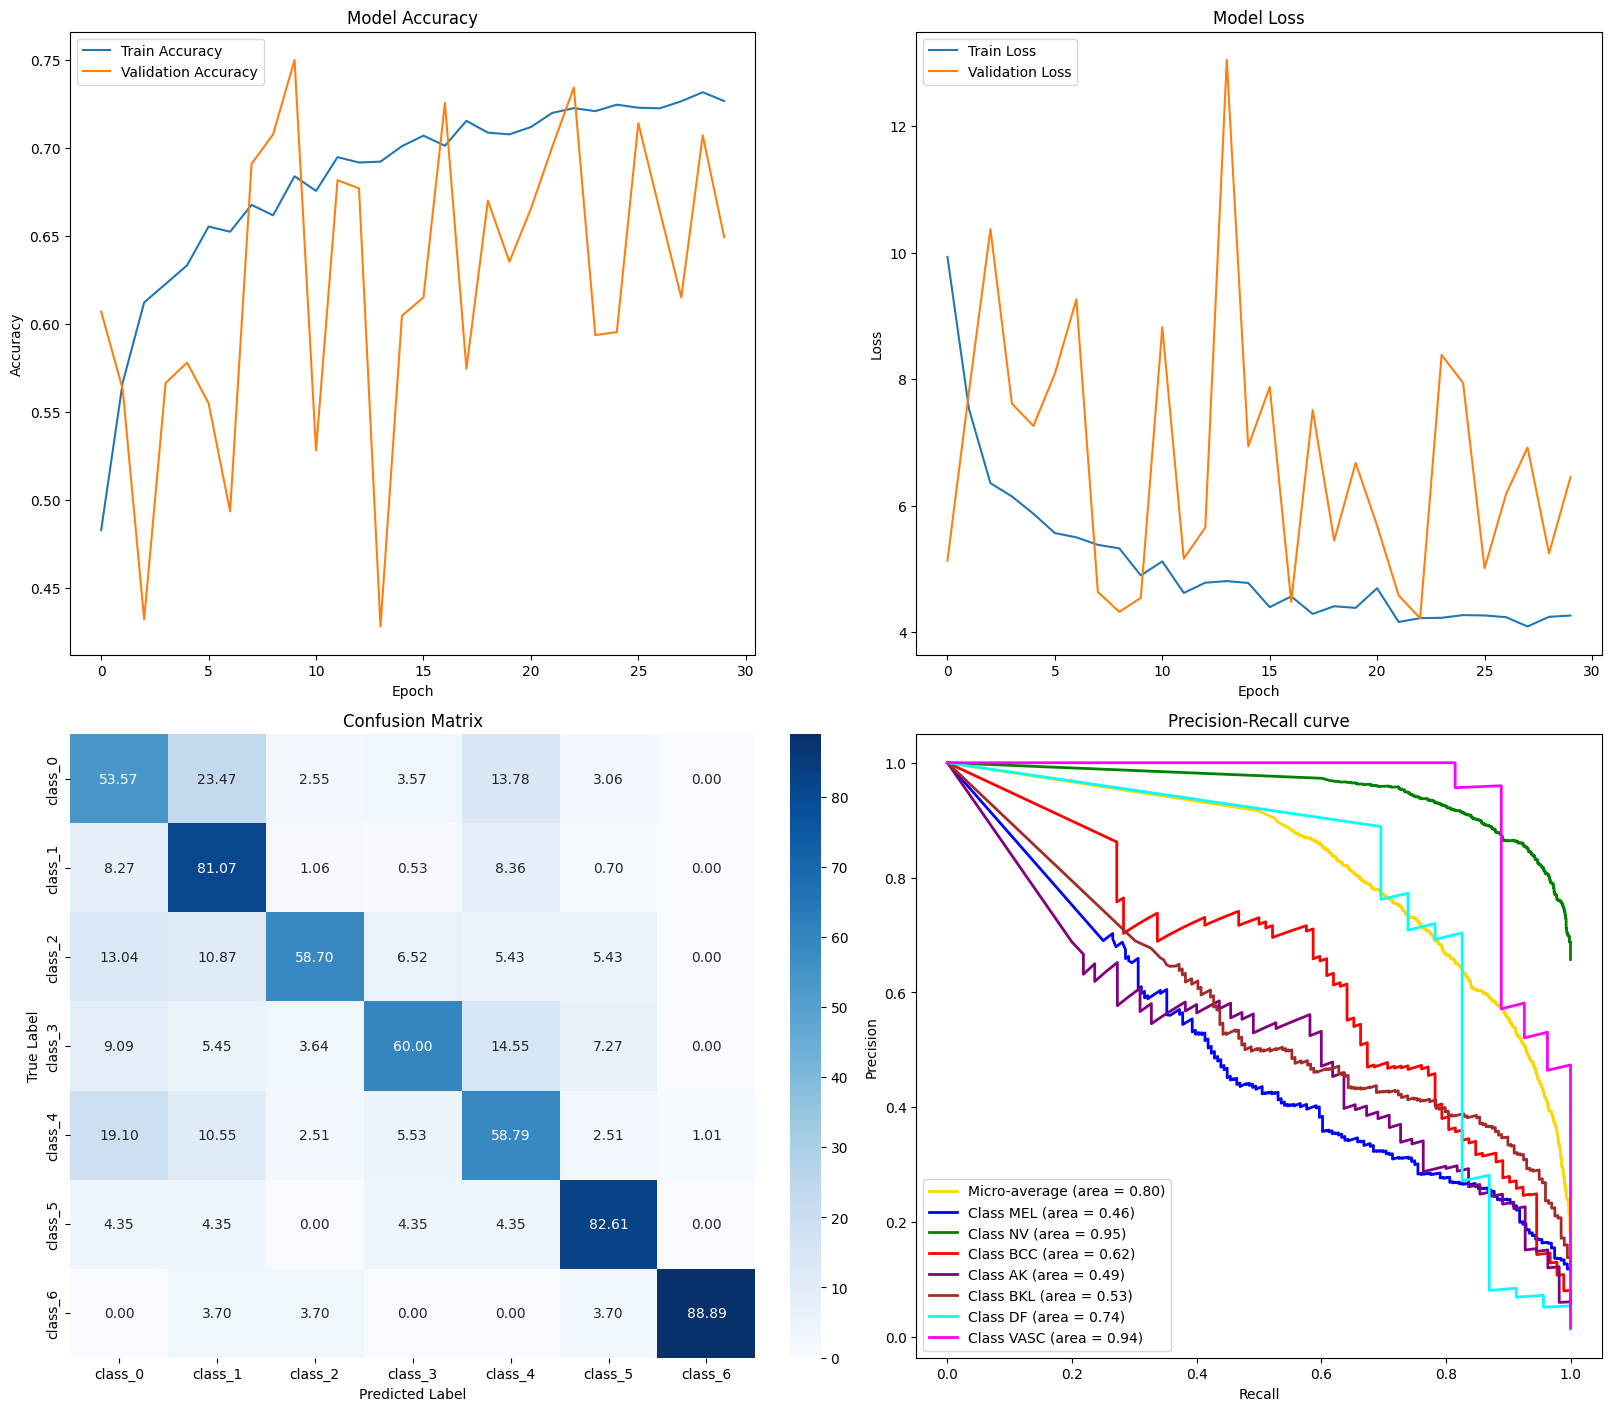

In [40]:
from tensorflow.keras.models import load_model
from plot_utils import show_all_plots

model = load_model(model_dir)

show_all_plots([history3_2], model, test_generator)

### Training 3

#### Util (dataloader without aug)

In [28]:
import os
import random
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence, to_categorical
from itertools import chain

class Dataloader(Sequence):
    def __init__(self, data, batch_size, image_size, is_validation=False, preprocess_function=None, class_distribuition=[], class_names=[]):
        #self.data_dir = data_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.isValidation = is_validation
        self.class_distribution = class_distribuition if not is_validation else []
        self.preprocess_function = preprocess_function

        self.datagen = ImageDataGenerator(
            horizontal_flip=True,
            vertical_flip=True,
            shear_range=15, 
            zoom_range=0.4,
            rotation_range=45, 
            brightness_range= [0.9, 1.5],
            fill_mode='nearest'
            )

        self.class_names = class_names
        self.num_classes = len(self.class_names)
        self.class_to_label = {class_name: i for i, class_name in enumerate(self.class_names)} # mapping {'class1': 0, 'class2': 1, ...})

        self.image_paths, self.labels = zip(*data)
        self.image_paths = list(self.image_paths)  # Convert from tuple to list
        self.labels = list(self.labels)           # Convert from tuple to list

        self.indexes_for_class = [[] for _ in range(self.num_classes)]

        self.all_image_indices = self._create_indices_distr() if not self.isValidation else list(range(len(self.image_paths)))
        self.samples = len(self.all_image_indices)
        #self._shuffle_indices()
        print(f"Found {len(self.image_paths)} images belonging to {self.num_classes} classes (dist says {sum(self.class_distribution)})")
        self._shuffle_indices()


    def _create_indices_distr(self):
        for index, label in enumerate(self.labels):
            self.indexes_for_class[label].append(index) # I assume its list 4 has all the indexes for label class_5

        res = list(chain.from_iterable(self.indexes_for_class)) # flattens the list-of-lists to one list
        return res



    def _load_data(self):
        image_paths = []
        labels = []
        for class_name in self.class_names:
            class_dir = os.path.join(self.data_dir, class_name)
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                image_paths.append(image_path)
                labels.append(self.class_to_label[class_name])

        #print(f"Found {len(image_paths)} images belonging to {self.num_classes} classes (dist says {sum(self.class_distribution)})")
        return image_paths, labels

    def _preprocess_image(self, image_path):
        img = load_img(image_path, target_size=self.image_size)
        x = img_to_array(img)

        # if not self.isValidation:
        #     x = x.reshape((1,) + x.shape)
        #     x = next(self.datagen.flow(x, batch_size=1))[0]

        if self.preprocess_function:
            x = self.preprocess_function(x)
        return x

    def _shuffle_indices(self):
        random.shuffle(self.all_image_indices)


    def __len__(self):
        num_samples = len(self.all_image_indices) # no_images=100 batchsize=20, then 100/20=5 number of iterations to get through the whole dataset
        return num_samples // self.batch_size
    
    def __getitem__(self, index):
        start = index * self.batch_size
        end = start + self.batch_size
        images = []
        labels = []

        batch_image_indices = self.all_image_indices[start:end]

        for image_index in batch_image_indices:
            image_path = self.image_paths[image_index]
            image = self._preprocess_image(image_path)
            images.append(image)
            labels.append(to_categorical(self.labels[image_index], num_classes=self.num_classes))

        return np.array(images), np.array(labels)

    def on_epoch_end(self):
        if not self.isValidation:
            self._shuffle_indices()




class DataloaderFactory():
    def __init__(self, dir, image_size, batch_size, set_distribution, class_distribution=[], preprocess_function=None):
        self.dir = dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.set_distribution = set_distribution
        self.class_distribution = class_distribution
        self.preprocess_function = preprocess_function
        self.class_names = []

    def _load_data(self):
        """Load images and labels as tuples (path, label)."""
        data = []
        self.class_names = sorted(os.listdir(self.dir))
        for label, class_name in enumerate(self.class_names):
            class_dir = os.path.join(self.dir, class_name)
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                data.append((image_path, label))  # Append (path, label) as a tuple
        return data

    def _split_data(self, data):
        """Split data into train, validation, and test sets based on the specified distribution."""
        indices = list(range(len(data)))
        _, val_ratio, test_ratio = [p / 100 for p in self.set_distribution]

        labels = [label for _, label in data]
        train_idxs, test_idxs, _, _ = train_test_split(
            indices, labels, test_size=(val_ratio + test_ratio), stratify=labels
        )
        val_split = val_ratio / (val_ratio + test_ratio)
        val_idxs, test_idxs = train_test_split(
            test_idxs, test_size=(1 - val_split), stratify=[labels[i] for i in test_idxs]
        )

        return {"train": train_idxs, "val": val_idxs, "test": test_idxs}

    def get_dataloaders(self):
        """Generate dataloaders for training, validation, and testing."""
        data = self._load_data()  # List of (path, label) tuples
        data_splits = self._split_data(data)  # Split data by indices
        loaders = {}

        for split, indexes in data_splits.items():
            preprocess_func = self.preprocess_function if split == "train" else None
            split_data = [data[i] for i in indexes]  # Subset the data using indices
            loaders[split] = Dataloader(
                data=split_data,  # Pass the list of tuples
                batch_size=self.batch_size,
                image_size=self.image_size,
                is_validation=(split != "train"),
                preprocess_function=preprocess_func,
                class_distribuition=self.class_distribution,
                class_names=self.class_names
            )

        return loaders["train"], loaders["val"], loaders["test"]

#### Training

In [29]:
data_dir = "Merge Set Ordered"
iteration = "iteration_3_3"
model_dir = f'models/best_model_{iteration}.h5'

In [30]:

from keras.applications.mobilenet_v3 import preprocess_input

batch_size=32
dist = []
print(sum(dist))
histories = []

factory = DataloaderFactory(data_dir, batch_size=batch_size, image_size=(224,224), set_distribution=(70,15,15), class_distribution=dist, preprocess_function=preprocess_input)

train_generator, validation_generator, test_generator = factory.get_dataloaders()

0
Found 8202 images belonging to 7 classes (dist says 0)
Found 1758 images belonging to 7 classes (dist says 0)
Found 1758 images belonging to 7 classes (dist says 0)


In [31]:
from keras.applications import MobileNetV3Small
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import SGD

base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
      layer.trainable = False

  # Add custom layers for classification
x = base_model.output
x = Flatten()(x)
preds = Dense(7,activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=preds)

sgd = SGD()

# Compile model - make it trainable
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [33]:
image_counts = {}
total_count = 0

train_dir = "Data Set Ordered/training data/"
for subdir in os.listdir(train_dir):
    subdir_path = os.path.join(train_dir, subdir)
    
    if os.path.isdir(subdir_path):
        # Count files in the subdirectory (assuming all files are images)
        num_images = len([f for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))])
        
        # Store the count in the dictionary
        image_counts[subdir] = num_images
        total_count += num_images

weights = {}

for subdir, count in image_counts.items():
    weight = total_count / (7 * count)
    weights.update({int(subdir.split("_")[1]): weight})

print("Weights: ", weights)

Weights:  {4: 1.301832835044846, 3: 4.375273044997815, 2: 2.78349082823791, 5: 12.440993788819876, 0: 1.2854575792581184, 6: 10.075452716297788, 1: 0.21338020666879728}


In [34]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=model_dir,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',  
    patience=15,          
    min_delta=0.001      
)

# Train the model with the callback
history3_3 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    verbose=1,
    class_weight=weights,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/30
256/256 [==============================] - ETA: 0s - loss: 27.1564 - accuracy: 0.4482
Epoch 1: val_loss improved from inf to 11.83557, saving model to models/best_model_iteration_3_3.h5
256/256 [==============================] - 33s 124ms/step - loss: 27.1564 - accuracy: 0.4482 - val_loss: 11.8356 - val_accuracy: 0.6209
Epoch 2/30


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


256/256 [==============================] - ETA: 0s - loss: 10.0972 - accuracy: 0.6261
Epoch 2: val_loss did not improve from 11.83557
256/256 [==============================] - 32s 126ms/step - loss: 10.0972 - accuracy: 0.6261 - val_loss: 17.9839 - val_accuracy: 0.4659
Epoch 3/30
256/256 [==============================] - ETA: 0s - loss: 5.4607 - accuracy: 0.6969
Epoch 3: val_loss improved from 11.83557 to 8.74267, saving model to models/best_model_iteration_3_3.h5
256/256 [==============================] - 33s 129ms/step - loss: 5.4607 - accuracy: 0.6969 - val_loss: 8.7427 - val_accuracy: 0.6453
Epoch 4/30
256/256 [==============================] - ETA: 0s - loss: 4.0020 - accuracy: 0.7609
Epoch 4: val_loss improved from 8.74267 to 7.19163, saving model to models/best_model_iteration_3_3.h5
256/256 [==============================] - 36s 140ms/step - loss: 4.0020 - accuracy: 0.7609 - val_loss: 7.1916 - val_accuracy: 0.6748
Epoch 5/30
256/256 [==============================] - ETA: 0s -

['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6']
Balanced Accuracy: 0.6289933425029116
Accuracy on test set: 0.7627314925193787
F1 Score: 0.7651265703293392


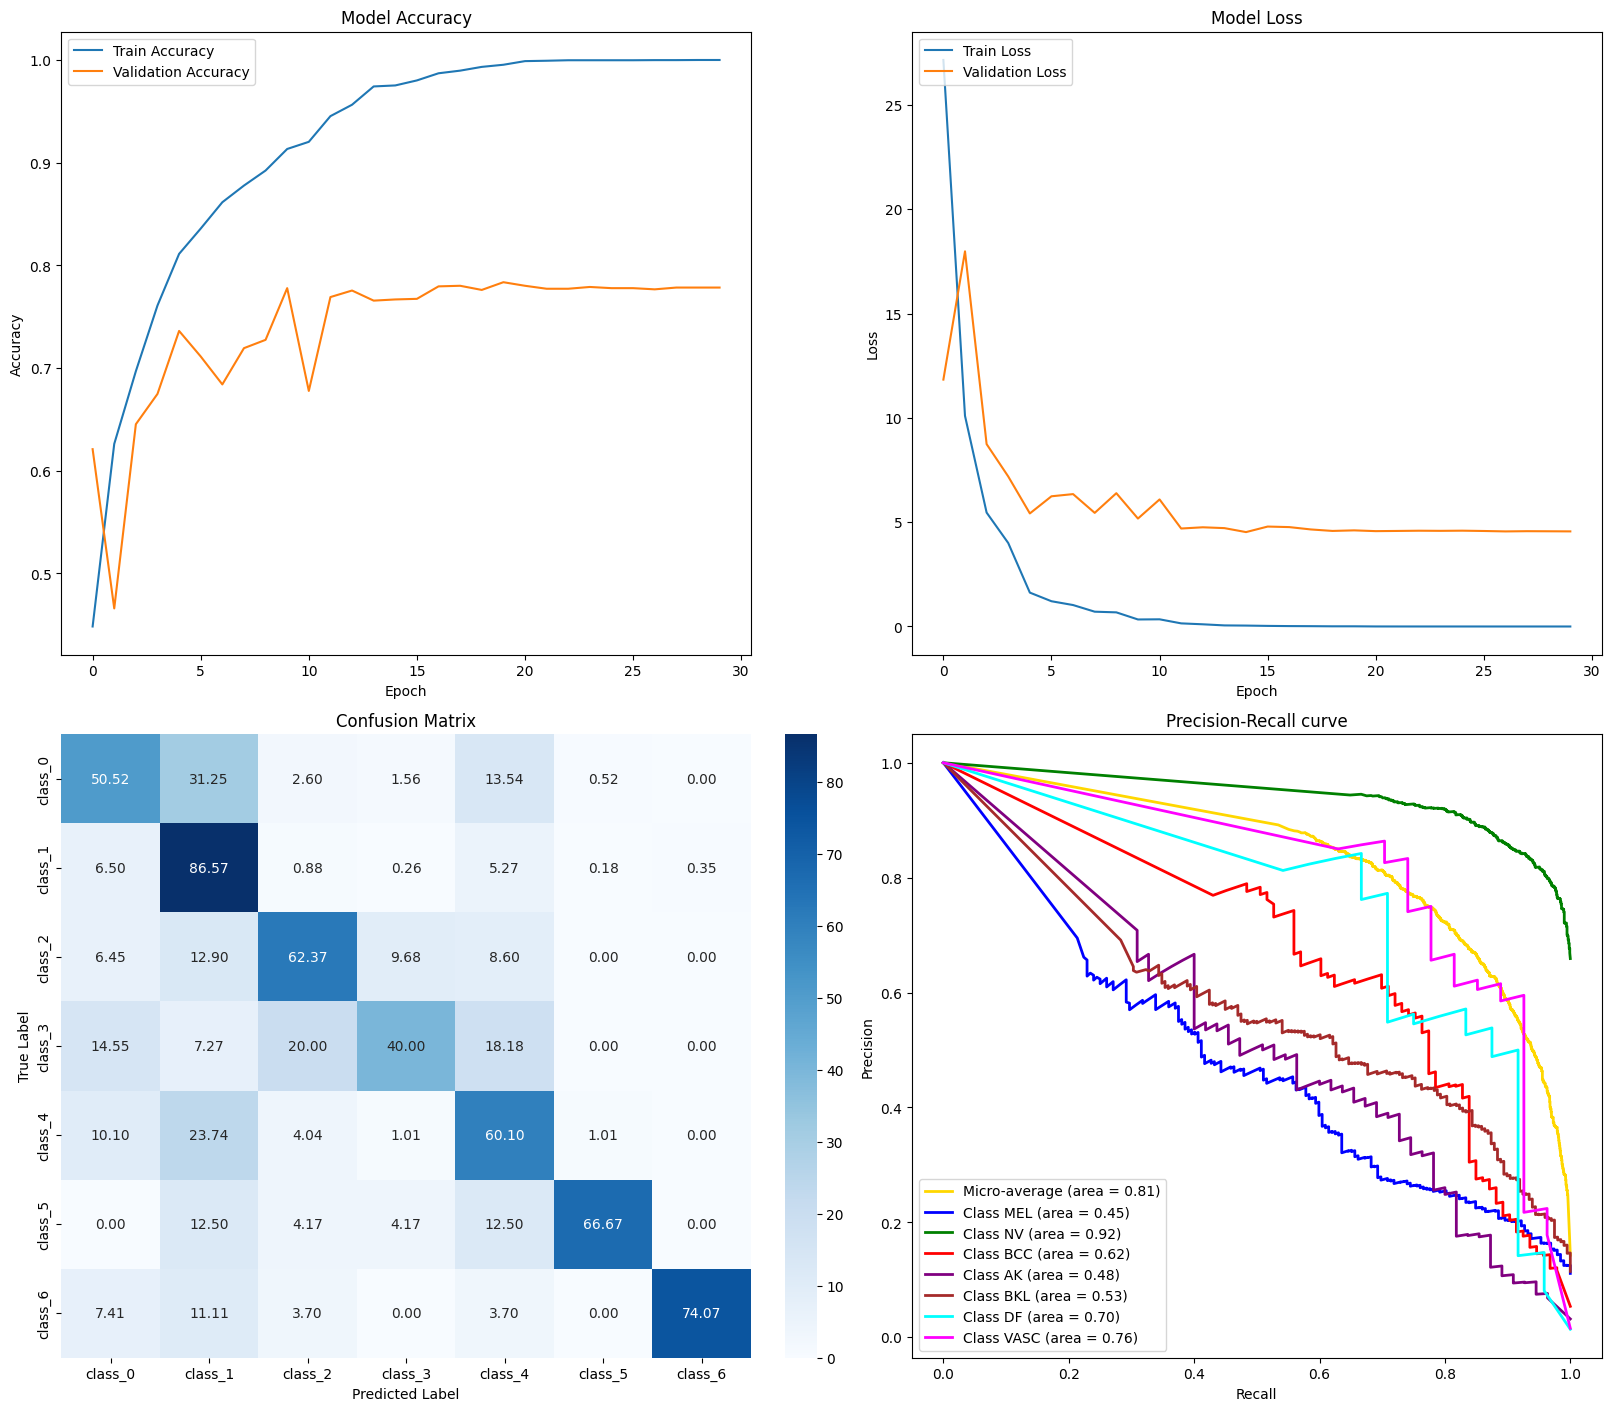

In [35]:
from tensorflow.keras.models import load_model
from plot_utils import show_all_plots

model = load_model(model_dir)

show_all_plots([history3_3], model, test_generator)

## Iteration 4

Here we experiment with LR rate. In particular we use "Jeremy's approch" with cyclic learning rate.

### Utils (old model)

In [78]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


class CustomModel(tf.keras.Model):
    def __init__(self, number_of_samples):
        super(CustomModel, self).__init__()
        
        # Load and configure the base model
        base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        
        for layer in base_model.layers:
            layer.trainable = False
        
        # Add custom layers for classification
        x = base_model.output
        x = Flatten()(x)
        preds = Dense(7, activation='softmax')(x)

        # Define the complete model
        self.model = Model(inputs=base_model.input, outputs=preds)

        # Set cyclical learning rate parameters
        self.lower_bound = 1e-4
        self.upper_bound = 1e-3
        self.half_cycle_multiple = 6
        self.batch_size = 32
        self.steps_per_epoch = int(number_of_samples / self.batch_size)
        self.half_cycle_length = self.steps_per_epoch * self.half_cycle_multiple
        self.full_cycle_length = 2 * self.half_cycle_length
        self.learning_rates = []
        self.class_weight = None
        self.norms = []
        self.epochs = 5

    def compile(self):
        # Compile the internal model
        self.model.compile(optimizer=SGD(learning_rate=self.lower_bound), loss='categorical_crossentropy', metrics=['accuracy'])

    def evaluate(self, data):
        # Evaluate the model on the validation set
        return self.model.evaluate(data)
    
    def predict(self, data):
        return self.model.predict(data)
    


    def fit_epochs(self, train_generator, validation_generator, epochs, checkpoint_path, lr=None, class_weight=None):

        self.epochs = epochs

        if lr is not None:
            self.lower_bound = lr[0]
            self.upper_bound = lr[1]
        
        if class_weight is not None:
            self.class_weight = class_weight

        class GradientLogger(Callback):
            def __init__(self, model):
                super().__init__()
                self.model = model
                self.gradient_norms_log = []
                self.norms = []

            def on_epoch_end(self, epoch, logs=None):
                with tf.GradientTape() as tape:
                    norm = tf.sqrt(sum([tf.reduce_sum(tf.square(var)) for var in self.model.trainable_variables]))
                    self.norms.append(norm.numpy())

            def get_norms(self):
                return self.norms

        gradient_logger = GradientLogger(self.model)

        

        checkpoint_callback = ModelCheckpoint(
            filepath=checkpoint_path,
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=False,
            mode='min',
            verbose=1
        )

        early_stopping_callback = EarlyStopping(
            monitor='val_loss',  
            patience=40,          
            min_delta=0.001,
            start_from_epoch=5
        )

        # Train the model using the cyclical learning rate scheduler and checkpoint callback
        history = self.model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=epochs,
            batch_size=self.batch_size,
            verbose=1,
            class_weight=self.class_weight,
            callbacks=[self.lr_scheduler, checkpoint_callback, early_stopping_callback, gradient_logger]
        )

        self.norms = gradient_logger.get_norms()

        return history
    
    def plot_trainable_weights(self):
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, self.epochs + 1), self.norms, marker='o', label='Norm of Trainable Variables')
        plt.xlabel('Epoch')
        plt.ylabel('Norm')
        plt.title('Norm of Trainable Variables vs Epoch')
        plt.grid()
        plt.legend()
        plt.show()
    
    def evaluate(self, data):
        # Evaluate the model on the validation set
        return self.model.evaluate(data)

    def unfreeze(self):
        # Unfreeze all layers in the base model
        for layer in self.model.layers:
            layer.trainable = True
        print("All layers have been unfrozen.")

    def lr_find(self, train_generator, validation_generator, min_lr=1e-10, max_lr=0.01, epochs=10):
        steps_per_epoch = train_generator.samples / self.batch_size
        total_batches = steps_per_epoch * epochs
        
        # Custom callback for linear learning rate increase
        class LinearLRScheduler(Callback):
            def __init__(self, min_lr, max_lr, total_batches):
                super().__init__()
                self.min_lr = min_lr
                self.max_lr = max_lr
                self.total_batches = total_batches
                self.batch_count = 0
                self.lr_history = []
                self.loss_history = []

            def on_batch_end(self, batch, logs=None):
                # Log the loss and learning rate
                loss = logs.get('loss')
                self.loss_history.append(loss)
                
                # Incrementally increase learning rate
                self.batch_count += 1
                lr = self.min_lr + (self.max_lr - self.min_lr) * (self.batch_count / self.total_batches)
                tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)
                self.lr_history.append(lr)

        # Instantiate the linear learning rate scheduler callback
        lr_scheduler_callback = LinearLRScheduler(min_lr, max_lr, total_batches)
        
        # Compile the model with the minimum learning rate
        self.model.compile(optimizer=SGD(learning_rate=min_lr), loss='categorical_crossentropy', metrics=['accuracy'])
        
        # Train the model with the learning rate scheduler to find optimal lr
        self.model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=epochs,
            batch_size=self.batch_size,
            class_weight=self.class_weight,
            callbacks=[lr_scheduler_callback],
            verbose=1
        )

        # Plot learning rate vs. loss
        plt.plot(lr_scheduler_callback.lr_history, lr_scheduler_callback.loss_history)
        plt.xscale('log')
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.title('Loss vs. Learning Rate')
        plt.show()

    @property
    def lr_scheduler(self):
        # Custom cyclical learning rate scheduler
        class BatchLearningRateScheduler(tf.keras.callbacks.Callback):
            def __init__(self, lower_bound, upper_bound, full_cycle_length, learning_rates):
                super().__init__()
                self.lower_bound = lower_bound
                self.upper_bound = upper_bound
                self.full_cycle_length = full_cycle_length
                self.batch_count = 0
                self.learning_rates = learning_rates

            def on_batch_end(self, batch, logs=None):
                cycle_position = np.abs((self.batch_count % self.full_cycle_length) / self.full_cycle_length - 0.5) * 2
                lr = self.lower_bound + (self.upper_bound - self.lower_bound) * (1 - cycle_position)
                tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)
                self.learning_rates.append(lr)
                self.batch_count += 1

        return BatchLearningRateScheduler(self.lower_bound, self.upper_bound, self.full_cycle_length, self.learning_rates)

    


# Example usage:
# model = CustomModel(number_of_samples=1000)
# model.compile()
# model.fit_epochs(epochs=10, lr=0.001)
# model.unfreeze()
# lr_history = model.lr_find()


### Training

In [79]:
data_dir = "Merge Set Ordered"
iteration = "iteration_4"
model_dir = f'models/best_model_{iteration}.h5'

In [80]:

from keras.applications.mobilenet_v3 import preprocess_input

from homemade_dataloader import DataloaderFactory

batch_size=32
dist = [1171,1171,1171,1171,1171,1171,1171]
print(sum(dist))
histories = []

factory = DataloaderFactory(data_dir, batch_size=batch_size, image_size=(224,224), set_distribution=(70,15,15), class_distribution=dist, preprocess_function=preprocess_input)

train_generator, validation_generator, test_generator = factory.get_dataloaders()

8197
Loading data split from data_split.json
Found 8202 images belonging to 7 classes (dist says 8197)
Found 1758 images belonging to 7 classes (dist says 0)
Found 1758 images belonging to 7 classes (dist says 0)


In [81]:
model = CustomModel(number_of_samples=train_generator.samples)
model.compile()

In [82]:
history_4_transfer = model.fit_epochs(train_generator, validation_generator, epochs=5, checkpoint_path=model_dir)
histories.append(history_4_transfer)

Epoch 1/5
256/256 [==============================] - ETA: 0s - loss: 2.0322 - accuracy: 0.3290 
Epoch 1: val_loss improved from inf to 1.73175, saving model to models/best_model_iteration_4.h5
256/256 [==============================] - 2651s 10s/step - loss: 2.0322 - accuracy: 0.3290 - val_loss: 1.7317 - val_accuracy: 0.3848
Epoch 2/5


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


256/256 [==============================] - ETA: 0s - loss: 1.4094 - accuracy: 0.5081
Epoch 2: val_loss improved from 1.73175 to 1.17618, saving model to models/best_model_iteration_4.h5
256/256 [==============================] - 1936s 8s/step - loss: 1.4094 - accuracy: 0.5081 - val_loss: 1.1762 - val_accuracy: 0.5926
Epoch 3/5
256/256 [==============================] - ETA: 0s - loss: 1.2137 - accuracy: 0.5724
Epoch 3: val_loss did not improve from 1.17618
256/256 [==============================] - 454s 2s/step - loss: 1.2137 - accuracy: 0.5724 - val_loss: 1.2660 - val_accuracy: 0.5671
Epoch 4/5
256/256 [==============================] - ETA: 0s - loss: 1.1354 - accuracy: 0.6019
Epoch 4: val_loss improved from 1.17618 to 1.04374, saving model to models/best_model_iteration_4.h5
256/256 [==============================] - 69s 268ms/step - loss: 1.1354 - accuracy: 0.6019 - val_loss: 1.0437 - val_accuracy: 0.6291
Epoch 5/5
256/256 [==============================] - ETA: 0s - loss: 1.0539 -

All layers have been unfrozen.
Epoch 1/10
256/256 [==============================] - 86s 328ms/step - loss: 1.8434 - accuracy: 0.4838 - val_loss: 1.1857 - val_accuracy: 0.6481
Epoch 2/10
256/256 [==============================] - 84s 327ms/step - loss: 1.3816 - accuracy: 0.5936 - val_loss: 1.1355 - val_accuracy: 0.6493
Epoch 3/10
256/256 [==============================] - 83s 323ms/step - loss: 1.1650 - accuracy: 0.6521 - val_loss: 1.1647 - val_accuracy: 0.6418
Epoch 4/10
256/256 [==============================] - 83s 323ms/step - loss: 0.9809 - accuracy: 0.6807 - val_loss: 0.9171 - val_accuracy: 0.7211
Epoch 5/10
256/256 [==============================] - 84s 327ms/step - loss: 0.8393 - accuracy: 0.7162 - val_loss: 0.8855 - val_accuracy: 0.7205
Epoch 6/10
256/256 [==============================] - 84s 327ms/step - loss: 0.7476 - accuracy: 0.7393 - val_loss: 0.8774 - val_accuracy: 0.7112
Epoch 7/10
256/256 [==============================] - 83s 322ms/step - loss: 0.6928 - accuracy: 0.7

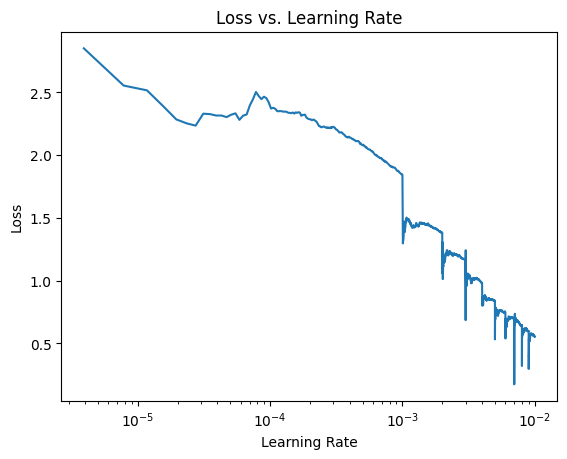

In [83]:
model.unfreeze()
model.lr_find(train_generator, validation_generator)

In [84]:
history_4_finetune = model.fit_epochs(
    train_generator, 
    validation_generator, 
    epochs=50, 
    checkpoint_path=model_dir, 
    lr=[1e-4, 1e-3])
histories.append(history_4_finetune)

Epoch 1/50
256/256 [==============================] - ETA: 0s - loss: 0.5258 - accuracy: 0.8141
Epoch 1: val_loss improved from inf to 0.80412, saving model to models/best_model_iteration_4.h5
256/256 [==============================] - 82s 319ms/step - loss: 0.5258 - accuracy: 0.8141 - val_loss: 0.8041 - val_accuracy: 0.7321
Epoch 2/50
256/256 [==============================] - ETA: 0s - loss: 0.5160 - accuracy: 0.8148
Epoch 2: val_loss improved from 0.80412 to 0.80047, saving model to models/best_model_iteration_4.h5
256/256 [==============================] - 82s 319ms/step - loss: 0.5160 - accuracy: 0.8148 - val_loss: 0.8005 - val_accuracy: 0.7355
Epoch 3/50
256/256 [==============================] - ETA: 0s - loss: 0.5073 - accuracy: 0.8224
Epoch 3: val_loss did not improve from 0.80047
256/256 [==============================] - 81s 317ms/step - loss: 0.5073 - accuracy: 0.8224 - val_loss: 0.8124 - val_accuracy: 0.7257
Epoch 4/50
256/256 [==============================] - ETA: 0s - l

['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6']
Balanced Accuracy: 0.6689226755065621
Accuracy on test set: 0.7471064925193787
F1 Score: 0.7625921625930596


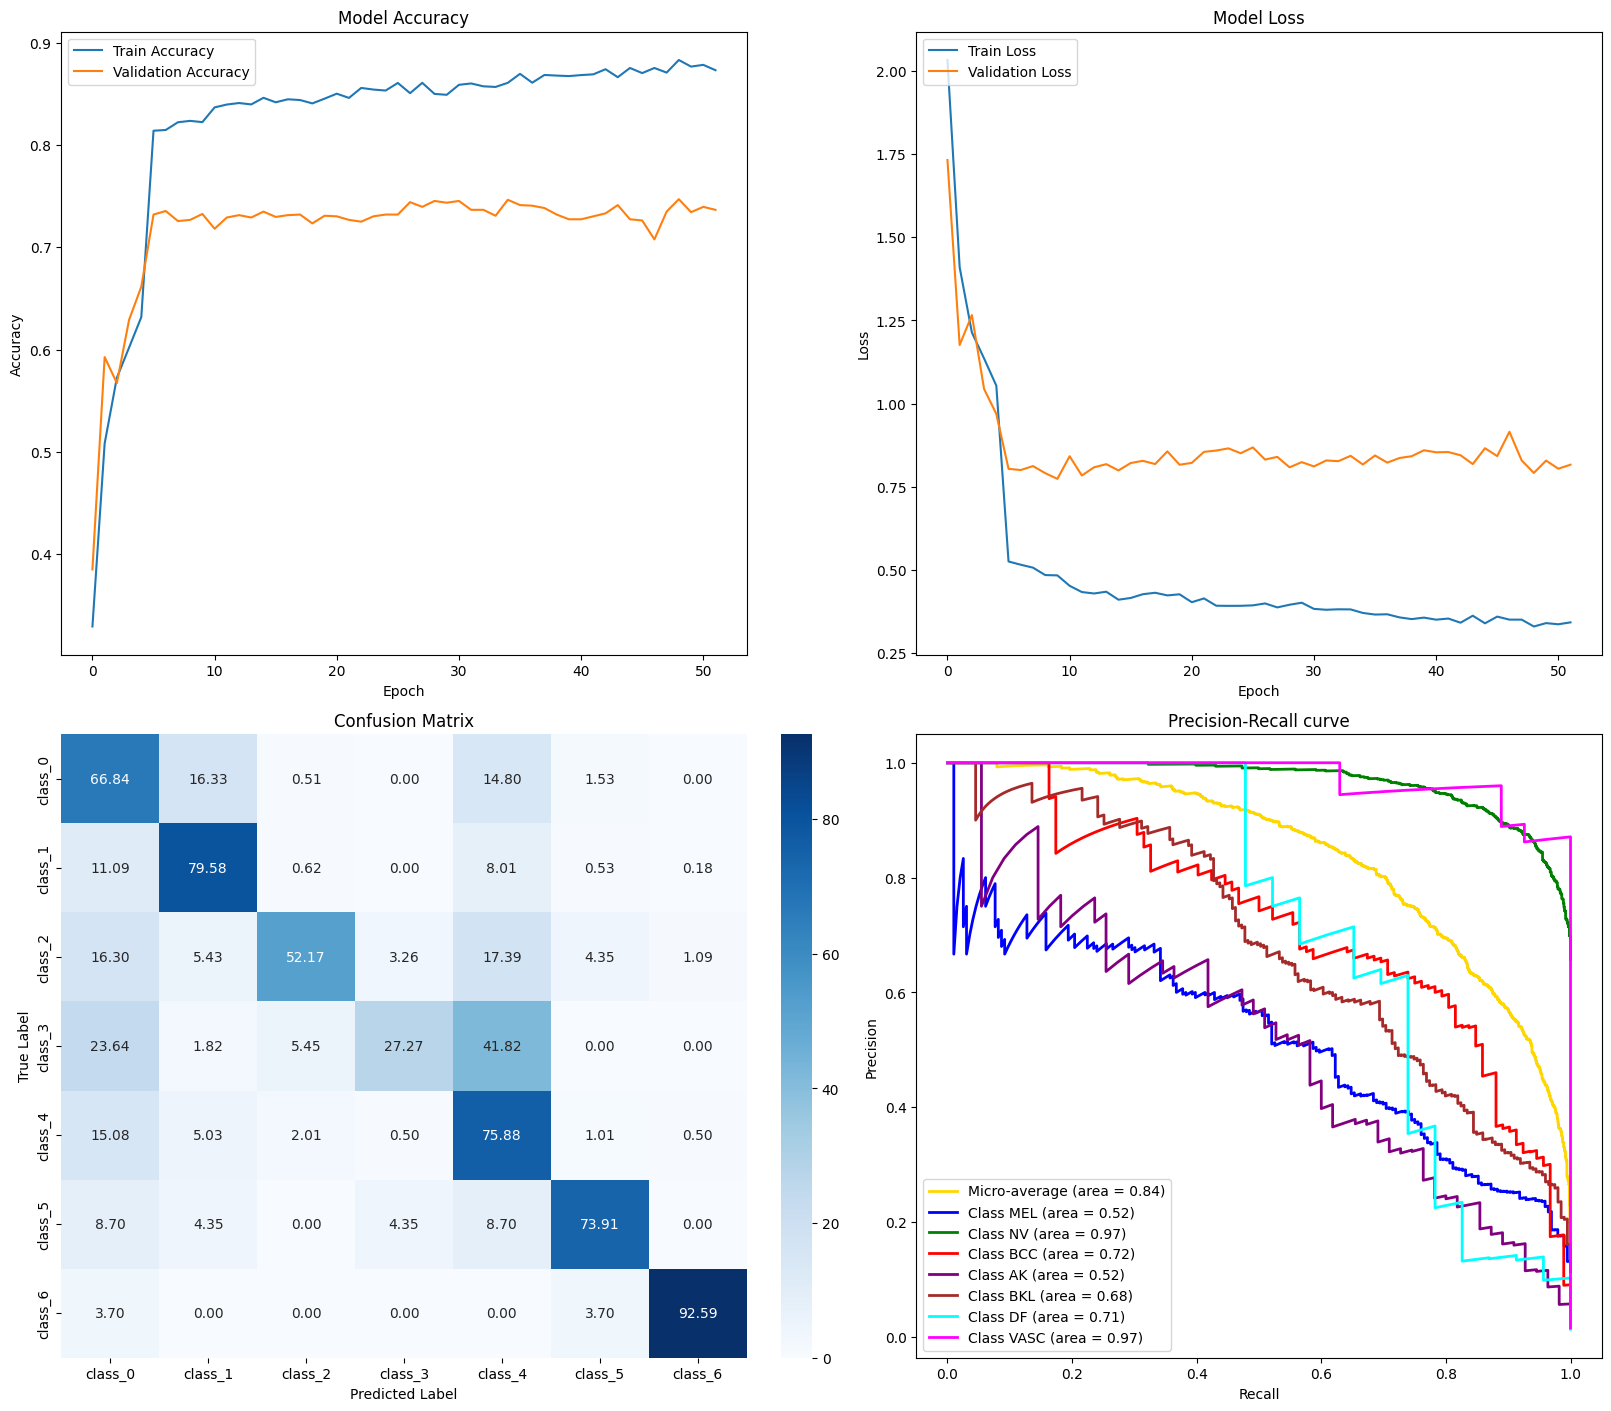

In [85]:
from tensorflow.keras.models import load_model
from plot_utils import show_all_plots


m = load_model(model_dir)

show_all_plots(histories, m, test_generator)

## Iteration 5

Here we try to compat overfitting

### Training 1

More data. We do this with augmentations

In [86]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


class CustomModel(tf.keras.Model):
    def __init__(self, number_of_samples):
        super(CustomModel, self).__init__()
        
        # Load and configure the base model
        base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        
        for layer in base_model.layers:
            layer.trainable = False
        
        # Add custom layers for classification
        x = base_model.output
        x = Flatten()(x)
        preds = Dense(7, activation='softmax')(x)

        # Define the complete model
        self.model = Model(inputs=base_model.input, outputs=preds)

        # Set cyclical learning rate parameters
        self.lower_bound = 1e-4
        self.upper_bound = 1e-3
        self.half_cycle_multiple = 6
        self.batch_size = 32
        self.steps_per_epoch = int(number_of_samples / self.batch_size)
        self.half_cycle_length = self.steps_per_epoch * self.half_cycle_multiple
        self.full_cycle_length = 2 * self.half_cycle_length
        self.learning_rates = []
        self.class_weight = None
        self.norms = []
        self.epochs = 5

    def compile(self):
        # Compile the internal model
        self.model.compile(optimizer=SGD(learning_rate=self.lower_bound), loss='categorical_crossentropy', metrics=['accuracy'])

    def evaluate(self, data):
        # Evaluate the model on the validation set
        return self.model.evaluate(data)
    
    def predict(self, data):
        return self.model.predict(data)
    


    def fit_epochs(self, train_generator, validation_generator, epochs, checkpoint_path, lr=None, class_weight=None):

        self.epochs = epochs

        if lr is not None:
            self.lower_bound = lr[0]
            self.upper_bound = lr[1]
        
        if class_weight is not None:
            self.class_weight = class_weight

        class GradientLogger(Callback):
            def __init__(self, model):
                super().__init__()
                self.model = model
                self.gradient_norms_log = []
                self.norms = []

            def on_epoch_end(self, epoch, logs=None):
                with tf.GradientTape() as tape:
                    norm = tf.sqrt(sum([tf.reduce_sum(tf.square(var)) for var in self.model.trainable_variables]))
                    self.norms.append(norm.numpy())

            def get_norms(self):
                return self.norms

        gradient_logger = GradientLogger(self.model)

        

        checkpoint_callback = ModelCheckpoint(
            filepath=checkpoint_path,
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=False,
            mode='min',
            verbose=1
        )

        early_stopping_callback = EarlyStopping(
            monitor='val_loss',  
            patience=40,          
            min_delta=0.001,
            start_from_epoch=5
        )

        # Train the model using the cyclical learning rate scheduler and checkpoint callback
        history = self.model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=epochs,
            batch_size=self.batch_size,
            verbose=1,
            class_weight=self.class_weight,
            callbacks=[self.lr_scheduler, checkpoint_callback, early_stopping_callback, gradient_logger]
        )

        self.norms = gradient_logger.get_norms()

        return history
    
    def plot_trainable_weights(self):
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, self.epochs + 1), self.norms, marker='o', label='Norm of Trainable Variables')
        plt.xlabel('Epoch')
        plt.ylabel('Norm')
        plt.title('Norm of Trainable Variables vs Epoch')
        plt.grid()
        plt.legend()
        plt.show()
    
    def evaluate(self, data):
        # Evaluate the model on the validation set
        return self.model.evaluate(data)

    def unfreeze(self):
        # Unfreeze all layers in the base model
        for layer in self.model.layers:
            layer.trainable = True
        print("All layers have been unfrozen.")

    def lr_find(self, train_generator, validation_generator, min_lr=1e-10, max_lr=0.01, epochs=10):
        steps_per_epoch = train_generator.samples / self.batch_size
        total_batches = steps_per_epoch * epochs
        
        # Custom callback for linear learning rate increase
        class LinearLRScheduler(Callback):
            def __init__(self, min_lr, max_lr, total_batches):
                super().__init__()
                self.min_lr = min_lr
                self.max_lr = max_lr
                self.total_batches = total_batches
                self.batch_count = 0
                self.lr_history = []
                self.loss_history = []

            def on_batch_end(self, batch, logs=None):
                # Log the loss and learning rate
                loss = logs.get('loss')
                self.loss_history.append(loss)
                
                # Incrementally increase learning rate
                self.batch_count += 1
                lr = self.min_lr + (self.max_lr - self.min_lr) * (self.batch_count / self.total_batches)
                tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)
                self.lr_history.append(lr)

        # Instantiate the linear learning rate scheduler callback
        lr_scheduler_callback = LinearLRScheduler(min_lr, max_lr, total_batches)
        
        # Compile the model with the minimum learning rate
        self.model.compile(optimizer=SGD(learning_rate=min_lr), loss='categorical_crossentropy', metrics=['accuracy'])
        
        # Train the model with the learning rate scheduler to find optimal lr
        self.model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=epochs,
            batch_size=self.batch_size,
            class_weight=self.class_weight,
            callbacks=[lr_scheduler_callback],
            verbose=1
        )

        # Plot learning rate vs. loss
        plt.plot(lr_scheduler_callback.lr_history, lr_scheduler_callback.loss_history)
        plt.xscale('log')
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.title('Loss vs. Learning Rate')
        plt.show()

    @property
    def lr_scheduler(self):
        # Custom cyclical learning rate scheduler
        class BatchLearningRateScheduler(tf.keras.callbacks.Callback):
            def __init__(self, lower_bound, upper_bound, full_cycle_length, learning_rates):
                super().__init__()
                self.lower_bound = lower_bound
                self.upper_bound = upper_bound
                self.full_cycle_length = full_cycle_length
                self.batch_count = 0
                self.learning_rates = learning_rates

            def on_batch_end(self, batch, logs=None):
                cycle_position = np.abs((self.batch_count % self.full_cycle_length) / self.full_cycle_length - 0.5) * 2
                lr = self.lower_bound + (self.upper_bound - self.lower_bound) * (1 - cycle_position)
                tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)
                self.learning_rates.append(lr)
                self.batch_count += 1

        return BatchLearningRateScheduler(self.lower_bound, self.upper_bound, self.full_cycle_length, self.learning_rates)

    


# Example usage:
# model = CustomModel(number_of_samples=1000)
# model.compile()
# model.fit_epochs(epochs=10, lr=0.001)
# model.unfreeze()
# lr_history = model.lr_find()

In [88]:
data_dir = "Merge Set Ordered"
iteration = "iteration_5_1"
model_dir = f'models/best_model_{iteration}.h5'

In [89]:
from keras.applications.mobilenet_v3 import preprocess_input


# Now import HomemadeDataloader from homemade_dataloader.py
from homemade_dataloader import DataloaderFactory


batch_size=32
dist = [4000,4000,4000,4000,4000,4000,4000]
print(sum(dist))
histories = []

factory = DataloaderFactory(data_dir, batch_size=batch_size, image_size=(224,224), set_distribution=(70,15,15), class_distribution=dist, preprocess_function=preprocess_input)

train_generator, validation_generator, test_generator = factory.get_dataloaders()

28000
Loading data split from data_split.json
Found 8202 images belonging to 7 classes (dist says 28000)
Found 1758 images belonging to 7 classes (dist says 0)
Found 1758 images belonging to 7 classes (dist says 0)


In [90]:
model = CustomModel(number_of_samples=train_generator.samples)
model.compile()

In [91]:
history_5_1_transfer = model.fit_epochs(train_generator, validation_generator, epochs=5, checkpoint_path=model_dir)
histories.append(history_5_1_transfer)

Epoch 1/5
875/875 [==============================] - ETA: 0s - loss: 1.6330 - accuracy: 0.4431
Epoch 1: val_loss improved from inf to 1.31422, saving model to models/best_model_iteration_5_1.h5
875/875 [==============================] - 215s 244ms/step - loss: 1.6330 - accuracy: 0.4431 - val_loss: 1.3142 - val_accuracy: 0.5405
Epoch 2/5


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


875/875 [==============================] - ETA: 0s - loss: 1.1158 - accuracy: 0.6030
Epoch 2: val_loss improved from 1.31422 to 1.04111, saving model to models/best_model_iteration_5_1.h5
875/875 [==============================] - 211s 241ms/step - loss: 1.1158 - accuracy: 0.6030 - val_loss: 1.0411 - val_accuracy: 0.6499
Epoch 3/5
875/875 [==============================] - ETA: 0s - loss: 0.9668 - accuracy: 0.6537
Epoch 3: val_loss improved from 1.04111 to 0.93279, saving model to models/best_model_iteration_5_1.h5
875/875 [==============================] - 211s 241ms/step - loss: 0.9668 - accuracy: 0.6537 - val_loss: 0.9328 - val_accuracy: 0.6777
Epoch 4/5
875/875 [==============================] - ETA: 0s - loss: 0.8782 - accuracy: 0.6844
Epoch 4: val_loss improved from 0.93279 to 0.90618, saving model to models/best_model_iteration_5_1.h5
875/875 [==============================] - 201s 230ms/step - loss: 0.8782 - accuracy: 0.6844 - val_loss: 0.9062 - val_accuracy: 0.7049
Epoch 5/5
8

All layers have been unfrozen.
Epoch 1/5
875/875 [==============================] - 279s 316ms/step - loss: 1.4170 - accuracy: 0.5948 - val_loss: 1.0701 - val_accuracy: 0.6551
Epoch 2/5
875/875 [==============================] - 277s 317ms/step - loss: 0.8637 - accuracy: 0.7124 - val_loss: 1.0273 - val_accuracy: 0.6806
Epoch 3/5
875/875 [==============================] - 275s 314ms/step - loss: 0.6546 - accuracy: 0.7729 - val_loss: 1.0524 - val_accuracy: 0.6672
Epoch 4/5
875/875 [==============================] - 272s 310ms/step - loss: 0.5320 - accuracy: 0.8109 - val_loss: 1.0112 - val_accuracy: 0.6927
Epoch 5/5
875/875 [==============================] - 280s 319ms/step - loss: 0.4503 - accuracy: 0.8380 - val_loss: 0.7596 - val_accuracy: 0.7535


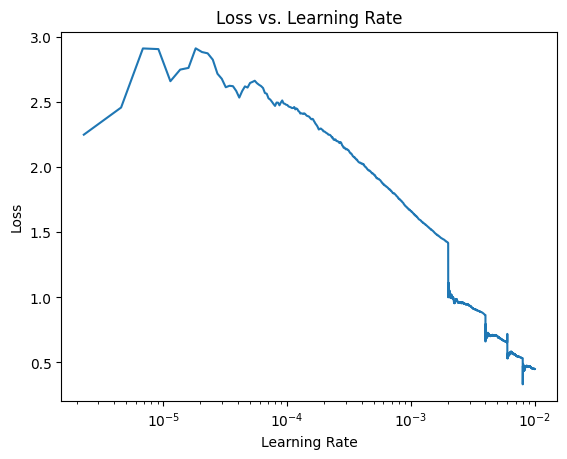

In [92]:
model.unfreeze()
model.lr_find(train_generator, validation_generator, epochs=5)

In [93]:
history_5_1_finetune = model.fit_epochs(
    train_generator, 
    validation_generator, 
    epochs=40, 
    checkpoint_path=model_dir, 
    lr=[1e-4, 8e-2]
    )
histories.append(history_5_1_finetune)

Epoch 1/40
875/875 [==============================] - ETA: 0s - loss: 0.3858 - accuracy: 0.8611
Epoch 1: val_loss improved from inf to 1.16006, saving model to models/best_model_iteration_5_1.h5
875/875 [==============================] - 277s 315ms/step - loss: 0.3858 - accuracy: 0.8611 - val_loss: 1.1601 - val_accuracy: 0.6713
Epoch 2/40


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


875/875 [==============================] - ETA: 0s - loss: 0.4168 - accuracy: 0.8546
Epoch 2: val_loss did not improve from 1.16006
875/875 [==============================] - 312s 356ms/step - loss: 0.4168 - accuracy: 0.8546 - val_loss: 1.3823 - val_accuracy: 0.6817
Epoch 3/40
875/875 [==============================] - ETA: 0s - loss: 0.4582 - accuracy: 0.8422
Epoch 3: val_loss did not improve from 1.16006
875/875 [==============================] - 286s 327ms/step - loss: 0.4582 - accuracy: 0.8422 - val_loss: 1.6875 - val_accuracy: 0.6638
Epoch 4/40
875/875 [==============================] - ETA: 0s - loss: 0.4504 - accuracy: 0.8477
Epoch 4: val_loss did not improve from 1.16006
875/875 [==============================] - 289s 329ms/step - loss: 0.4504 - accuracy: 0.8477 - val_loss: 1.4574 - val_accuracy: 0.6939
Epoch 5/40
875/875 [==============================] - ETA: 0s - loss: 0.5196 - accuracy: 0.8306
Epoch 5: val_loss did not improve from 1.16006
875/875 [=========================

['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6']
Balanced Accuracy: 0.7166106855957656
Accuracy on test set: 0.8130787014961243
F1 Score: 0.8184176725174486


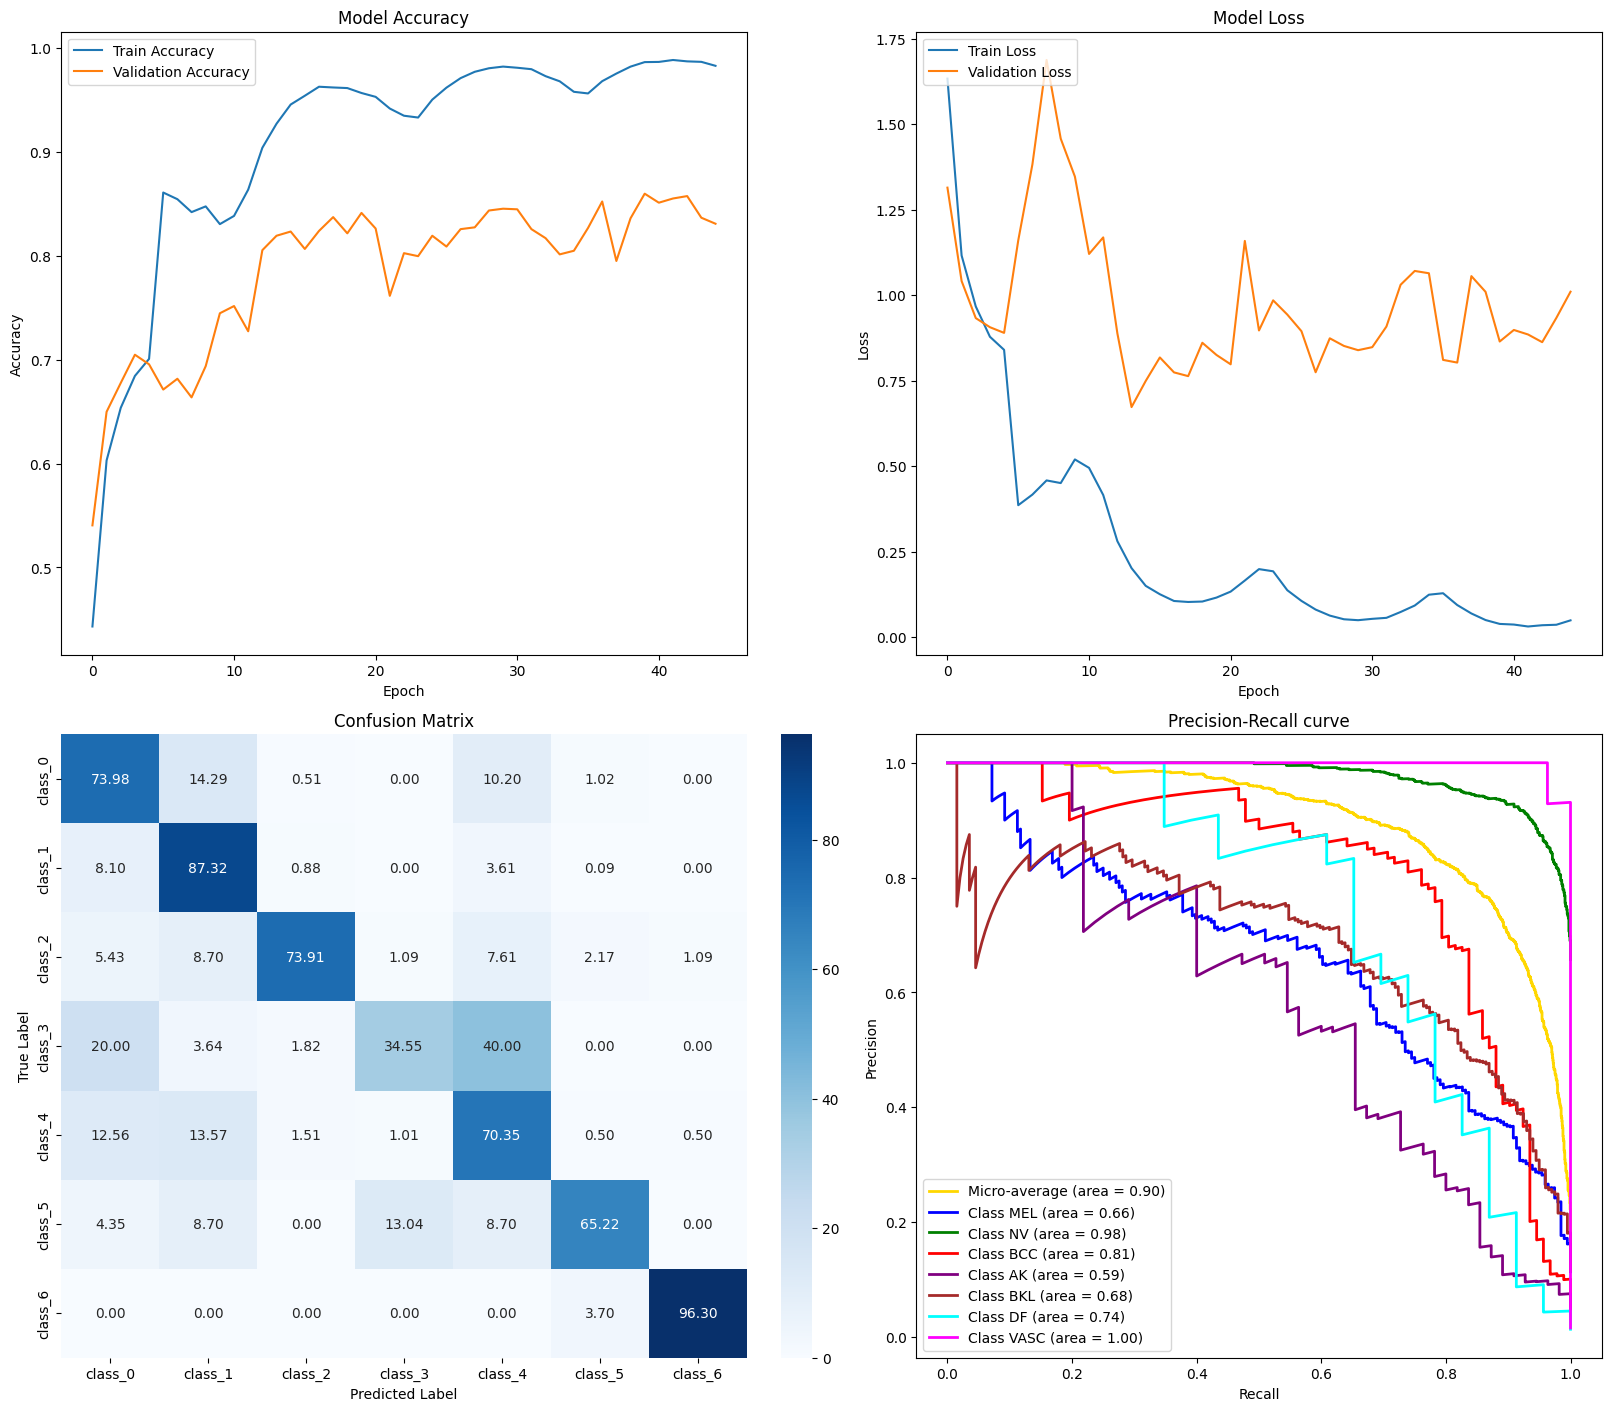

In [96]:
from tensorflow.keras.models import load_model
from plot_utils import show_all_plots


m = load_model(model_dir)

show_all_plots(histories, m, test_generator)

### Training 2

Dropout

In [97]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


class CustomModel(tf.keras.Model):
    def __init__(self, number_of_samples):
        super(CustomModel, self).__init__()
        
        # Load and configure the base model
        base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        
        for layer in base_model.layers:
            layer.trainable = False
        
        # Add custom layers for classification
        x = base_model.output
        x = Flatten()(x)
        x = Dropout(0.5)(x)
        preds = Dense(7, activation='softmax')(x)

        # Define the complete model
        self.model = Model(inputs=base_model.input, outputs=preds)

        # Set cyclical learning rate parameters
        self.lower_bound = 1e-4
        self.upper_bound = 1e-3
        self.half_cycle_multiple = 6
        self.batch_size = 32
        self.steps_per_epoch = int(number_of_samples / self.batch_size)
        self.half_cycle_length = self.steps_per_epoch * self.half_cycle_multiple
        self.full_cycle_length = 2 * self.half_cycle_length
        self.learning_rates = []
        self.class_weight = None
        self.norms = []
        self.epochs = 5

    def compile(self):
        # Compile the internal model
        self.model.compile(optimizer=SGD(learning_rate=self.lower_bound), loss='categorical_crossentropy', metrics=['accuracy'])

    def evaluate(self, data):
        # Evaluate the model on the validation set
        return self.model.evaluate(data)
    
    def predict(self, data):
        return self.model.predict(data)
    


    def fit_epochs(self, train_generator, validation_generator, epochs, checkpoint_path, lr=None, class_weight=None):

        self.epochs = epochs

        if lr is not None:
            self.lower_bound = lr[0]
            self.upper_bound = lr[1]
        
        if class_weight is not None:
            self.class_weight = class_weight

        class GradientLogger(Callback):
            def __init__(self, model):
                super().__init__()
                self.model = model
                self.gradient_norms_log = []
                self.norms = []

            def on_epoch_end(self, epoch, logs=None):
                with tf.GradientTape() as tape:
                    norm = tf.sqrt(sum([tf.reduce_sum(tf.square(var)) for var in self.model.trainable_variables]))
                    self.norms.append(norm.numpy())

            def get_norms(self):
                return self.norms

        gradient_logger = GradientLogger(self.model)

        

        checkpoint_callback = ModelCheckpoint(
            filepath=checkpoint_path,
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=False,
            mode='min',
            verbose=1
        )

        early_stopping_callback = EarlyStopping(
            monitor='val_loss',  
            patience=40,          
            min_delta=0.001,
            start_from_epoch=5
        )

        # Train the model using the cyclical learning rate scheduler and checkpoint callback
        history = self.model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=epochs,
            batch_size=self.batch_size,
            verbose=1,
            class_weight=self.class_weight,
            callbacks=[self.lr_scheduler, checkpoint_callback, early_stopping_callback, gradient_logger]
        )

        self.norms = gradient_logger.get_norms()

        return history
    
    def plot_trainable_weights(self):
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, self.epochs + 1), self.norms, marker='o', label='Norm of Trainable Variables')
        plt.xlabel('Epoch')
        plt.ylabel('Norm')
        plt.title('Norm of Trainable Variables vs Epoch')
        plt.grid()
        plt.legend()
        plt.show()
    
    def evaluate(self, data):
        # Evaluate the model on the validation set
        return self.model.evaluate(data)

    def unfreeze(self):
        # Unfreeze all layers in the base model
        for layer in self.model.layers:
            layer.trainable = True
        print("All layers have been unfrozen.")

    def lr_find(self, train_generator, validation_generator, min_lr=1e-10, max_lr=0.01, epochs=10):
        steps_per_epoch = train_generator.samples / self.batch_size
        total_batches = steps_per_epoch * epochs
        
        # Custom callback for linear learning rate increase
        class LinearLRScheduler(Callback):
            def __init__(self, min_lr, max_lr, total_batches):
                super().__init__()
                self.min_lr = min_lr
                self.max_lr = max_lr
                self.total_batches = total_batches
                self.batch_count = 0
                self.lr_history = []
                self.loss_history = []

            def on_batch_end(self, batch, logs=None):
                # Log the loss and learning rate
                loss = logs.get('loss')
                self.loss_history.append(loss)
                
                # Incrementally increase learning rate
                self.batch_count += 1
                lr = self.min_lr + (self.max_lr - self.min_lr) * (self.batch_count / self.total_batches)
                tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)
                self.lr_history.append(lr)

        # Instantiate the linear learning rate scheduler callback
        lr_scheduler_callback = LinearLRScheduler(min_lr, max_lr, total_batches)
        
        # Compile the model with the minimum learning rate
        self.model.compile(optimizer=SGD(learning_rate=min_lr), loss='categorical_crossentropy', metrics=['accuracy'])
        
        # Train the model with the learning rate scheduler to find optimal lr
        self.model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=epochs,
            batch_size=self.batch_size,
            class_weight=self.class_weight,
            callbacks=[lr_scheduler_callback],
            verbose=1
        )

        # Plot learning rate vs. loss
        plt.plot(lr_scheduler_callback.lr_history, lr_scheduler_callback.loss_history)
        plt.xscale('log')
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.title('Loss vs. Learning Rate')
        plt.show()

    @property
    def lr_scheduler(self):
        # Custom cyclical learning rate scheduler
        class BatchLearningRateScheduler(tf.keras.callbacks.Callback):
            def __init__(self, lower_bound, upper_bound, full_cycle_length, learning_rates):
                super().__init__()
                self.lower_bound = lower_bound
                self.upper_bound = upper_bound
                self.full_cycle_length = full_cycle_length
                self.batch_count = 0
                self.learning_rates = learning_rates

            def on_batch_end(self, batch, logs=None):
                cycle_position = np.abs((self.batch_count % self.full_cycle_length) / self.full_cycle_length - 0.5) * 2
                lr = self.lower_bound + (self.upper_bound - self.lower_bound) * (1 - cycle_position)
                tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)
                self.learning_rates.append(lr)
                self.batch_count += 1

        return BatchLearningRateScheduler(self.lower_bound, self.upper_bound, self.full_cycle_length, self.learning_rates)

    


# Example usage:
# model = CustomModel(number_of_samples=1000)
# model.compile()
# model.fit_epochs(epochs=10, lr=0.001)
# model.unfreeze()
# lr_history = model.lr_find()

In [98]:
data_dir = "Merge Set Ordered"
iteration = "iteration_5.2"
model_dir = f'models/best_model_{iteration}.h5'

In [99]:
from keras.applications.mobilenet_v3 import preprocess_input


# Now import HomemadeDataloader from homemade_dataloader.py
from homemade_dataloader import DataloaderFactory


batch_size=32
dist = [1171,1171,1171,1171,1171,1171,1171]
print(sum(dist))
histories = []

factory = DataloaderFactory(data_dir, batch_size=batch_size, image_size=(224,224), set_distribution=(70,15,15), class_distribution=dist, preprocess_function=preprocess_input)

train_generator, validation_generator, test_generator = factory.get_dataloaders()

8197
Loading data split from data_split.json
Found 8202 images belonging to 7 classes (dist says 8197)
Found 1758 images belonging to 7 classes (dist says 0)
Found 1758 images belonging to 7 classes (dist says 0)


In [102]:
model = CustomModel(number_of_samples=train_generator.samples)
model.compile()

In [103]:
history_5_2_transfer = model.fit_epochs(train_generator, validation_generator, epochs=5, checkpoint_path=model_dir)
histories.append(history_5_2_transfer)

Epoch 1/5
256/256 [==============================] - ETA: 0s - loss: 3.0226 - accuracy: 0.2627
Epoch 1: val_loss improved from inf to 1.41352, saving model to models/best_model_iteration_5.2.h5
256/256 [==============================] - 85s 324ms/step - loss: 3.0226 - accuracy: 0.2627 - val_loss: 1.4135 - val_accuracy: 0.5081
Epoch 2/5


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


256/256 [==============================] - ETA: 0s - loss: 2.1300 - accuracy: 0.4305
Epoch 2: val_loss improved from 1.41352 to 1.24887, saving model to models/best_model_iteration_5.2.h5
256/256 [==============================] - 77s 299ms/step - loss: 2.1300 - accuracy: 0.4305 - val_loss: 1.2489 - val_accuracy: 0.5885
Epoch 3/5
256/256 [==============================] - ETA: 0s - loss: 1.8743 - accuracy: 0.4846
Epoch 3: val_loss improved from 1.24887 to 1.05635, saving model to models/best_model_iteration_5.2.h5
256/256 [==============================] - 74s 290ms/step - loss: 1.8743 - accuracy: 0.4846 - val_loss: 1.0563 - val_accuracy: 0.6568
Epoch 4/5
256/256 [==============================] - ETA: 0s - loss: 1.7089 - accuracy: 0.5306
Epoch 4: val_loss did not improve from 1.05635
256/256 [==============================] - 74s 291ms/step - loss: 1.7089 - accuracy: 0.5306 - val_loss: 1.2783 - val_accuracy: 0.6117
Epoch 5/5
256/256 [==============================] - ETA: 0s - loss: 1

All layers have been unfrozen.
Epoch 1/10
256/256 [==============================] - 125s 480ms/step - loss: 2.7069 - accuracy: 0.4474 - val_loss: 1.1954 - val_accuracy: 0.6753
Epoch 2/10
256/256 [==============================] - 97s 378ms/step - loss: 1.8777 - accuracy: 0.5494 - val_loss: 1.3052 - val_accuracy: 0.6516
Epoch 3/10
256/256 [==============================] - 99s 385ms/step - loss: 1.4321 - accuracy: 0.6053 - val_loss: 1.2285 - val_accuracy: 0.6557
Epoch 4/10
256/256 [==============================] - 98s 383ms/step - loss: 1.1637 - accuracy: 0.6278 - val_loss: 1.1068 - val_accuracy: 0.6499
Epoch 5/10
256/256 [==============================] - 97s 377ms/step - loss: 0.9981 - accuracy: 0.6622 - val_loss: 1.3975 - val_accuracy: 0.5741
Epoch 6/10
256/256 [==============================] - 96s 375ms/step - loss: 0.8990 - accuracy: 0.6903 - val_loss: 1.0860 - val_accuracy: 0.6667
Epoch 7/10
256/256 [==============================] - 96s 374ms/step - loss: 0.8209 - accuracy: 0.

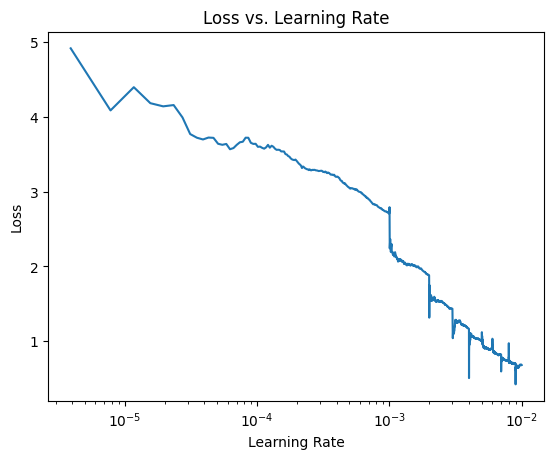

In [104]:
model.unfreeze()
model.lr_find(train_generator, validation_generator, epochs=10)

In [105]:
history_5_2_finetune = model.fit_epochs(
    train_generator, 
    validation_generator, 
    epochs=30, 
    checkpoint_path=model_dir, 
    lr=[1e-4, 1e-3]
    )
histories.append(history_5_2_finetune)

Epoch 1/30
256/256 [==============================] - ETA: 0s - loss: 0.6305 - accuracy: 0.7681
Epoch 1: val_loss improved from inf to 0.88363, saving model to models/best_model_iteration_5.2.h5
256/256 [==============================] - 89s 348ms/step - loss: 0.6305 - accuracy: 0.7681 - val_loss: 0.8836 - val_accuracy: 0.7043
Epoch 2/30


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


256/256 [==============================] - ETA: 0s - loss: 0.6167 - accuracy: 0.7804
Epoch 2: val_loss improved from 0.88363 to 0.82927, saving model to models/best_model_iteration_5.2.h5
256/256 [==============================] - 82s 319ms/step - loss: 0.6167 - accuracy: 0.7804 - val_loss: 0.8293 - val_accuracy: 0.7153
Epoch 3/30
256/256 [==============================] - ETA: 0s - loss: 0.6189 - accuracy: 0.7740
Epoch 3: val_loss improved from 0.82927 to 0.82097, saving model to models/best_model_iteration_5.2.h5
256/256 [==============================] - 83s 322ms/step - loss: 0.6189 - accuracy: 0.7740 - val_loss: 0.8210 - val_accuracy: 0.7199
Epoch 4/30
256/256 [==============================] - ETA: 0s - loss: 0.6018 - accuracy: 0.7827
Epoch 4: val_loss did not improve from 0.82097
256/256 [==============================] - 85s 331ms/step - loss: 0.6018 - accuracy: 0.7827 - val_loss: 0.8310 - val_accuracy: 0.7141
Epoch 5/30
256/256 [==============================] - ETA: 0s - loss

['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6']
Balanced Accuracy: 0.6736267802635962
Accuracy on test set: 0.7280092835426331
F1 Score: 0.7475400467200592


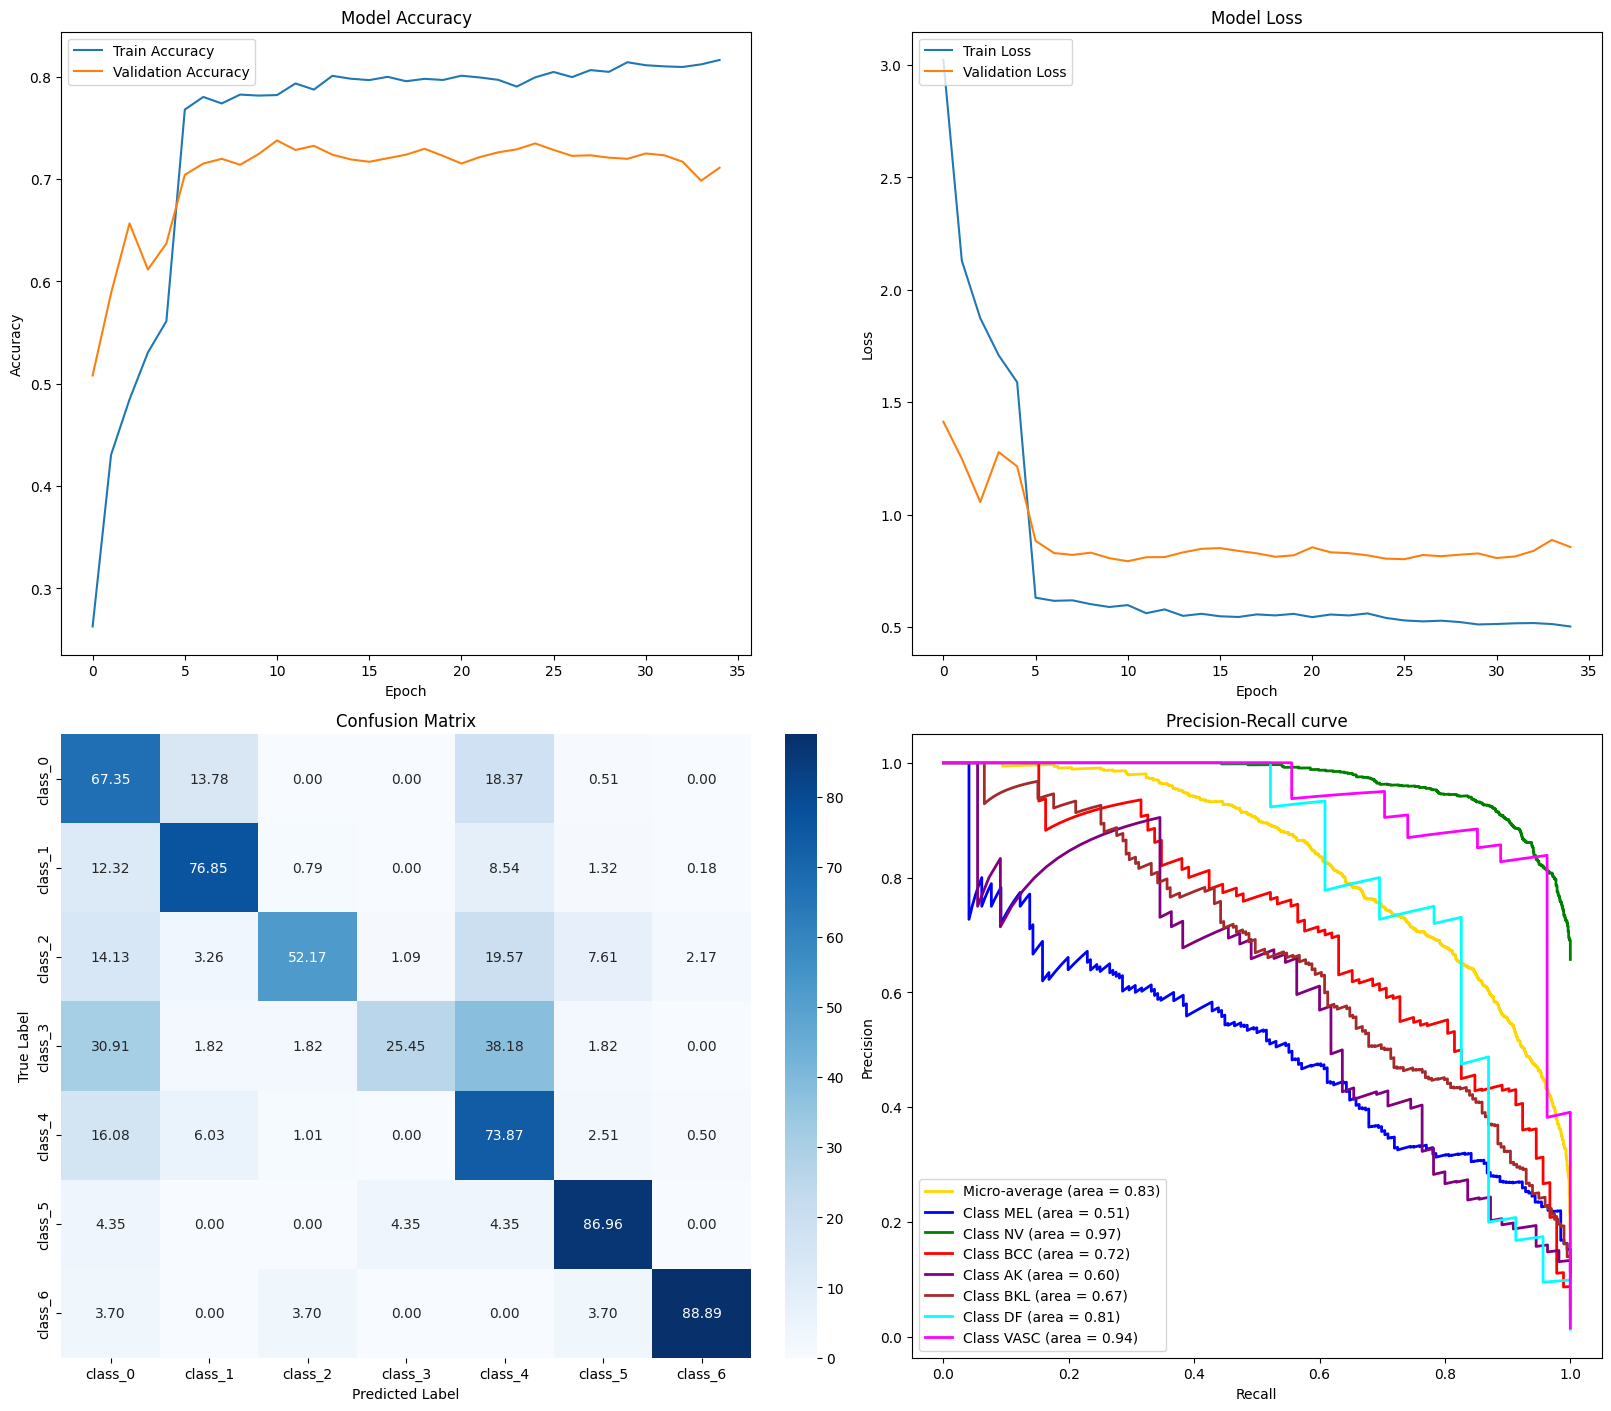

In [106]:
from tensorflow.keras.models import load_model
from plot_utils import show_all_plots


m = load_model(model_dir)

show_all_plots(histories, m, test_generator)

### Training 3

Batch normalization

In [107]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


class CustomModel(tf.keras.Model):
    def __init__(self, number_of_samples):
        super(CustomModel, self).__init__()
        
        # Load and configure the base model
        base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        
        for layer in base_model.layers:
            layer.trainable = False
        
        # Add custom layers for classification
        x = base_model.output
        x = Flatten()(x)
        x = BatchNormalization()(x)
        preds = Dense(7, activation='softmax')(x)

        # Define the complete model
        self.model = Model(inputs=base_model.input, outputs=preds)

        # Set cyclical learning rate parameters
        self.lower_bound = 1e-4
        self.upper_bound = 1e-3
        self.half_cycle_multiple = 6
        self.batch_size = 32
        self.steps_per_epoch = int(number_of_samples / self.batch_size)
        self.half_cycle_length = self.steps_per_epoch * self.half_cycle_multiple
        self.full_cycle_length = 2 * self.half_cycle_length
        self.learning_rates = []
        self.class_weight = None
        self.norms = []
        self.epochs = 5

    def compile(self):
        # Compile the internal model
        self.model.compile(optimizer=SGD(learning_rate=self.lower_bound), loss='categorical_crossentropy', metrics=['accuracy'])

    def evaluate(self, data):
        # Evaluate the model on the validation set
        return self.model.evaluate(data)
    
    def predict(self, data):
        return self.model.predict(data)
    


    def fit_epochs(self, train_generator, validation_generator, epochs, checkpoint_path, lr=None, class_weight=None):

        self.epochs = epochs

        if lr is not None:
            self.lower_bound = lr[0]
            self.upper_bound = lr[1]
        
        if class_weight is not None:
            self.class_weight = class_weight

        class GradientLogger(Callback):
            def __init__(self, model):
                super().__init__()
                self.model = model
                self.gradient_norms_log = []
                self.norms = []

            def on_epoch_end(self, epoch, logs=None):
                with tf.GradientTape() as tape:
                    norm = tf.sqrt(sum([tf.reduce_sum(tf.square(var)) for var in self.model.trainable_variables]))
                    self.norms.append(norm.numpy())

            def get_norms(self):
                return self.norms

        gradient_logger = GradientLogger(self.model)

        

        checkpoint_callback = ModelCheckpoint(
            filepath=checkpoint_path,
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=False,
            mode='min',
            verbose=1
        )

        early_stopping_callback = EarlyStopping(
            monitor='val_loss',  
            patience=40,          
            min_delta=0.001,
            start_from_epoch=5
        )

        # Train the model using the cyclical learning rate scheduler and checkpoint callback
        history = self.model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=epochs,
            batch_size=self.batch_size,
            verbose=1,
            class_weight=self.class_weight,
            callbacks=[self.lr_scheduler, checkpoint_callback, early_stopping_callback, gradient_logger]
        )

        self.norms = gradient_logger.get_norms()

        return history
    
    def plot_trainable_weights(self):
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, self.epochs + 1), self.norms, marker='o', label='Norm of Trainable Variables')
        plt.xlabel('Epoch')
        plt.ylabel('Norm')
        plt.title('Norm of Trainable Variables vs Epoch')
        plt.grid()
        plt.legend()
        plt.show()
    
    def evaluate(self, data):
        # Evaluate the model on the validation set
        return self.model.evaluate(data)

    def unfreeze(self):
        # Unfreeze all layers in the base model
        for layer in self.model.layers:
            layer.trainable = True
        print("All layers have been unfrozen.")

    def lr_find(self, train_generator, validation_generator, min_lr=1e-10, max_lr=0.01, epochs=10):
        steps_per_epoch = train_generator.samples / self.batch_size
        total_batches = steps_per_epoch * epochs
        
        # Custom callback for linear learning rate increase
        class LinearLRScheduler(Callback):
            def __init__(self, min_lr, max_lr, total_batches):
                super().__init__()
                self.min_lr = min_lr
                self.max_lr = max_lr
                self.total_batches = total_batches
                self.batch_count = 0
                self.lr_history = []
                self.loss_history = []

            def on_batch_end(self, batch, logs=None):
                # Log the loss and learning rate
                loss = logs.get('loss')
                self.loss_history.append(loss)
                
                # Incrementally increase learning rate
                self.batch_count += 1
                lr = self.min_lr + (self.max_lr - self.min_lr) * (self.batch_count / self.total_batches)
                tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)
                self.lr_history.append(lr)

        # Instantiate the linear learning rate scheduler callback
        lr_scheduler_callback = LinearLRScheduler(min_lr, max_lr, total_batches)
        
        # Compile the model with the minimum learning rate
        self.model.compile(optimizer=SGD(learning_rate=min_lr), loss='categorical_crossentropy', metrics=['accuracy'])
        
        # Train the model with the learning rate scheduler to find optimal lr
        self.model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=epochs,
            batch_size=self.batch_size,
            class_weight=self.class_weight,
            callbacks=[lr_scheduler_callback],
            verbose=1
        )

        # Plot learning rate vs. loss
        plt.plot(lr_scheduler_callback.lr_history, lr_scheduler_callback.loss_history)
        plt.xscale('log')
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.title('Loss vs. Learning Rate')
        plt.show()

    @property
    def lr_scheduler(self):
        # Custom cyclical learning rate scheduler
        class BatchLearningRateScheduler(tf.keras.callbacks.Callback):
            def __init__(self, lower_bound, upper_bound, full_cycle_length, learning_rates):
                super().__init__()
                self.lower_bound = lower_bound
                self.upper_bound = upper_bound
                self.full_cycle_length = full_cycle_length
                self.batch_count = 0
                self.learning_rates = learning_rates

            def on_batch_end(self, batch, logs=None):
                cycle_position = np.abs((self.batch_count % self.full_cycle_length) / self.full_cycle_length - 0.5) * 2
                lr = self.lower_bound + (self.upper_bound - self.lower_bound) * (1 - cycle_position)
                tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)
                self.learning_rates.append(lr)
                self.batch_count += 1

        return BatchLearningRateScheduler(self.lower_bound, self.upper_bound, self.full_cycle_length, self.learning_rates)

    


# Example usage:
# model = CustomModel(number_of_samples=1000)
# model.compile()
# model.fit_epochs(epochs=10, lr=0.001)
# model.unfreeze()
# lr_history = model.lr_find()

In [108]:
data_dir = "Merge Set Ordered"
iteration = "iteration_5.3"
model_dir = f'models/best_model_{iteration}.h5'

In [109]:
from keras.applications.mobilenet_v3 import preprocess_input


# Now import HomemadeDataloader from homemade_dataloader.py
from homemade_dataloader import DataloaderFactory


batch_size=32
dist = [1171,1171,1171,1171,1171,1171,1171]
print(sum(dist))
histories = []

factory = DataloaderFactory(data_dir, batch_size=batch_size, image_size=(224,224), set_distribution=(70,15,15), class_distribution=dist, preprocess_function=preprocess_input)

train_generator, validation_generator, test_generator = factory.get_dataloaders()

8197
Loading data split from data_split.json
Found 8202 images belonging to 7 classes (dist says 8197)
Found 1758 images belonging to 7 classes (dist says 0)
Found 1758 images belonging to 7 classes (dist says 0)


In [110]:
model = CustomModel(number_of_samples=train_generator.samples)
model.compile()

In [111]:
history_5_3_transfer = model.fit_epochs(train_generator, validation_generator, epochs=5, checkpoint_path=model_dir)
histories.append(history_5_3_transfer)

Epoch 1/5
256/256 [==============================] - ETA: 0s - loss: 2.2269 - accuracy: 0.2375
Epoch 1: val_loss improved from inf to 1.85862, saving model to models/best_model_iteration_5.3.h5
256/256 [==============================] - 69s 264ms/step - loss: 2.2269 - accuracy: 0.2375 - val_loss: 1.8586 - val_accuracy: 0.3287
Epoch 2/5


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


256/256 [==============================] - ETA: 0s - loss: 1.6929 - accuracy: 0.4016
Epoch 2: val_loss improved from 1.85862 to 1.44945, saving model to models/best_model_iteration_5.3.h5
256/256 [==============================] - 65s 253ms/step - loss: 1.6929 - accuracy: 0.4016 - val_loss: 1.4495 - val_accuracy: 0.4838
Epoch 3/5
256/256 [==============================] - ETA: 0s - loss: 1.4142 - accuracy: 0.4902
Epoch 3: val_loss improved from 1.44945 to 1.33697, saving model to models/best_model_iteration_5.3.h5
256/256 [==============================] - 69s 270ms/step - loss: 1.4142 - accuracy: 0.4902 - val_loss: 1.3370 - val_accuracy: 0.5266
Epoch 4/5
256/256 [==============================] - ETA: 0s - loss: 1.2603 - accuracy: 0.5560
Epoch 4: val_loss improved from 1.33697 to 1.25789, saving model to models/best_model_iteration_5.3.h5
256/256 [==============================] - 81s 316ms/step - loss: 1.2603 - accuracy: 0.5560 - val_loss: 1.2579 - val_accuracy: 0.5590
Epoch 5/5
256/

All layers have been unfrozen.
Epoch 1/10
256/256 [==============================] - 137s 526ms/step - loss: 1.5746 - accuracy: 0.4532 - val_loss: 1.2095 - val_accuracy: 0.5758
Epoch 2/10
256/256 [==============================] - 119s 464ms/step - loss: 1.2548 - accuracy: 0.5604 - val_loss: 0.9249 - val_accuracy: 0.6817
Epoch 3/10
256/256 [==============================] - 100s 390ms/step - loss: 1.0862 - accuracy: 0.6237 - val_loss: 0.9363 - val_accuracy: 0.7147
Epoch 4/10
256/256 [==============================] - 101s 394ms/step - loss: 0.9727 - accuracy: 0.6749 - val_loss: 0.8484 - val_accuracy: 0.7483
Epoch 5/10
256/256 [==============================] - 102s 399ms/step - loss: 0.8988 - accuracy: 0.7001 - val_loss: 0.9272 - val_accuracy: 0.7199
Epoch 6/10
256/256 [==============================] - 100s 391ms/step - loss: 0.9131 - accuracy: 0.7047 - val_loss: 1.2578 - val_accuracy: 0.6539
Epoch 7/10
256/256 [==============================] - 100s 391ms/step - loss: 0.8627 - accura

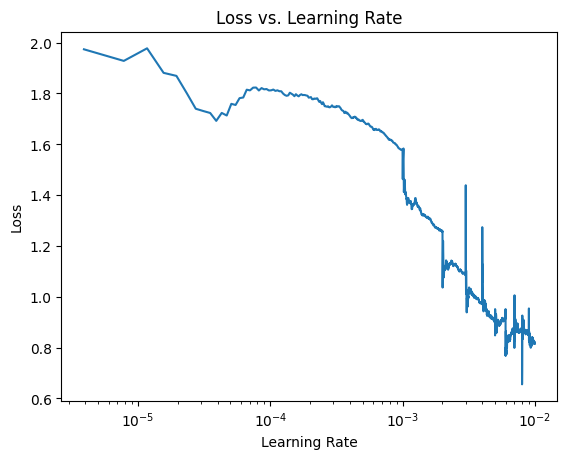

In [112]:
model.unfreeze()
model.lr_find(train_generator, validation_generator, epochs=10)

In [113]:
history_5_3_finetune = model.fit_epochs(
    train_generator, 
    validation_generator, 
    epochs=30, 
    checkpoint_path=model_dir, 
    lr=[1e-4, 2e-3]
    )
histories.append(history_5_3_finetune)

Epoch 1/30
256/256 [==============================] - ETA: 0s - loss: 0.7502 - accuracy: 0.7762
Epoch 1: val_loss improved from inf to 1.39069, saving model to models/best_model_iteration_5.3.h5
256/256 [==============================] - 83s 321ms/step - loss: 0.7502 - accuracy: 0.7762 - val_loss: 1.3907 - val_accuracy: 0.6863
Epoch 2/30
256/256 [==============================] - ETA: 0s - loss: 0.7177 - accuracy: 0.7782
Epoch 2: val_loss improved from 1.39069 to 1.29828, saving model to models/best_model_iteration_5.3.h5
256/256 [==============================] - 82s 321ms/step - loss: 0.7177 - accuracy: 0.7782 - val_loss: 1.2983 - val_accuracy: 0.6927
Epoch 3/30
256/256 [==============================] - ETA: 0s - loss: 0.6376 - accuracy: 0.7993
Epoch 3: val_loss improved from 1.29828 to 1.21534, saving model to models/best_model_iteration_5.3.h5
256/256 [==============================] - 83s 322ms/step - loss: 0.6376 - accuracy: 0.7993 - val_loss: 1.2153 - val_accuracy: 0.6921
Epoch

['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6']
Balanced Accuracy: 0.6415709404274631
Accuracy on test set: 0.7361111044883728
F1 Score: 0.7510889939415757


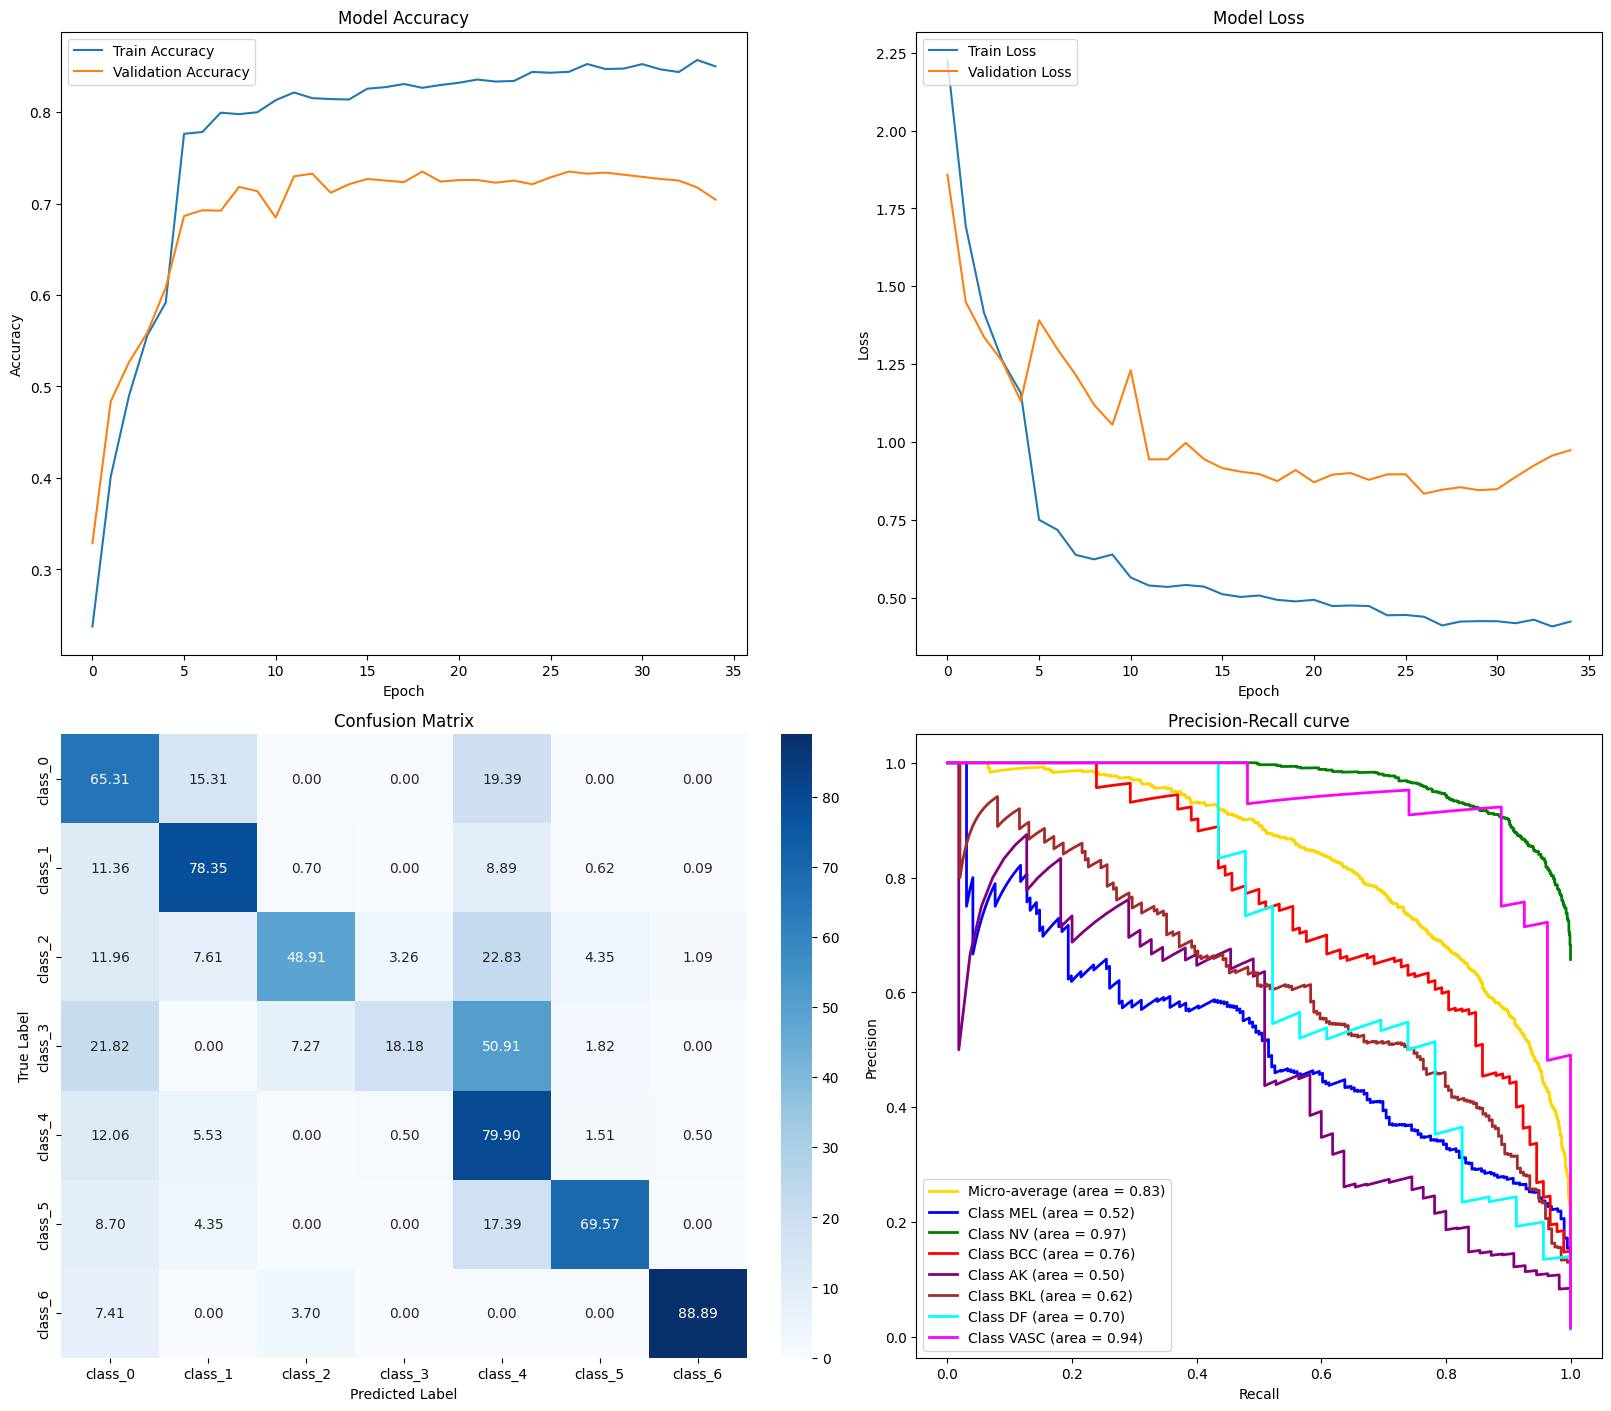

In [114]:
from tensorflow.keras.models import load_model
from plot_utils import show_all_plots


m = load_model(model_dir)

show_all_plots(histories, m, test_generator)

In [ ]:
data_dir = "Merge Set Ordered"
iteration = "iteration_5.2"
model_dir = f'models/best_model_{iteration}.h5'

In [ ]:
from keras.applications.mobilenet_v3 import preprocess_input


# Now import HomemadeDataloader from homemade_dataloader.py
from homemade_dataloader import DataloaderFactory


batch_size=32
dist = [1171,1171,1171,1171,1171,1171,1171]
print(sum(dist))
histories = []

factory = DataloaderFactory(data_dir, batch_size=batch_size, image_size=(224,224), set_distribution=(70,15,15), class_distribution=dist, preprocess_function=preprocess_input)

train_generator, validation_generator, test_generator = factory.get_dataloaders()

In [ ]:
model = CustomModel(number_of_samples=train_generator.samples)
model.compile()

In [ ]:
history_5_2_transfer = model.fit_epochs(train_generator, validation_generator, epochs=5, checkpoint_path=model_dir)
histories.append(history_5_2_transfer)

In [ ]:
model.unfreeze()
model.lr_find(train_generator, validation_generator, epochs=5)

In [ ]:
history_5_2_finetune = model.fit_epochs(
    train_generator, 
    validation_generator, 
    epochs=40, 
    checkpoint_path=model_dir, 
    lr=[1e-4, 2e-3]
    )
histories.append(history_5_2_finetune)

In [ ]:
from tensorflow.keras.models import load_model
from plot_utils import show_all_plots


m = load_model(model_dir)

show_all_plots(histories, m, test_generator)

## Iteration 6

Here we add a new Decoder - everything else is as we have always done

In [1]:
data_dir = "Merge Set Ordered"
iteration = "iteration_6"
model_dir = f'models/best_model_{iteration}.h5'

In [2]:
from keras.applications.mobilenet_v3 import preprocess_input

# Now import HomemadeDataloader from homemade_dataloader.py
from homemade_dataloader import DataloaderFactory

batch_size=32
dist = [4000,4000,4000,4000,4000,4000,4000]
histories = []

factory = DataloaderFactory(data_dir, batch_size=batch_size, image_size=(224,224), set_distribution=(70,15,15), class_distribution=dist, preprocess_function=preprocess_input)

train_generator, validation_generator, test_generator = factory.get_dataloaders()

/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Loading data split from data_split.json
Found 8202 images belonging to 7 classes (dist says 28000)
Found 1758 images belonging to 7 classes (dist says 0)
Found 1758 images belonging to 7 classes (dist says 0)


In [ ]:
from custom_model import CustomModel

model = CustomModel(number_of_samples=train_generator.samples)
model.compile()

In [4]:
history_6_transfer = model.fit_epochs(train_generator, validation_generator, epochs=5, checkpoint_path=model_dir)
histories.append(history_6_transfer)

Epoch 1/5
875/875 [==============================] - ETA: 0s - loss: 2.1528 - accuracy: 0.1734
Epoch 1: val_loss improved from inf to 1.93107, saving model to models/best_model_iteration_6.h5
875/875 [==============================] - 225s 256ms/step - loss: 2.1528 - accuracy: 0.1734 - val_loss: 1.9311 - val_accuracy: 0.2569
Epoch 2/5


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


875/875 [==============================] - ETA: 0s - loss: 1.7929 - accuracy: 0.3100
Epoch 2: val_loss improved from 1.93107 to 1.69370, saving model to models/best_model_iteration_6.h5
875/875 [==============================] - 221s 253ms/step - loss: 1.7929 - accuracy: 0.3100 - val_loss: 1.6937 - val_accuracy: 0.3507
Epoch 3/5
875/875 [==============================] - ETA: 0s - loss: 1.5461 - accuracy: 0.4218
Epoch 3: val_loss improved from 1.69370 to 1.49497, saving model to models/best_model_iteration_6.h5
875/875 [==============================] - 220s 252ms/step - loss: 1.5461 - accuracy: 0.4218 - val_loss: 1.4950 - val_accuracy: 0.4416
Epoch 4/5
875/875 [==============================] - ETA: 0s - loss: 1.3775 - accuracy: 0.4917
Epoch 4: val_loss improved from 1.49497 to 1.35521, saving model to models/best_model_iteration_6.h5
875/875 [==============================] - 211s 241ms/step - loss: 1.3775 - accuracy: 0.4917 - val_loss: 1.3552 - val_accuracy: 0.4954
Epoch 5/5
875/875

All layers have been unfrozen.
Epoch 1/5
875/875 [==============================] - 303s 343ms/step - loss: 1.4560 - accuracy: 0.4485 - val_loss: 1.0671 - val_accuracy: 0.5966
Epoch 2/5
875/875 [==============================] - 293s 334ms/step - loss: 0.9901 - accuracy: 0.6367 - val_loss: 0.7759 - val_accuracy: 0.7135
Epoch 3/5
875/875 [==============================] - 272s 311ms/step - loss: 0.7515 - accuracy: 0.7276 - val_loss: 0.7559 - val_accuracy: 0.7199
Epoch 4/5
875/875 [==============================] - 281s 321ms/step - loss: 0.5998 - accuracy: 0.7820 - val_loss: 0.7861 - val_accuracy: 0.7008
Epoch 5/5
875/875 [==============================] - 291s 331ms/step - loss: 0.5001 - accuracy: 0.8183 - val_loss: 0.7317 - val_accuracy: 0.7263


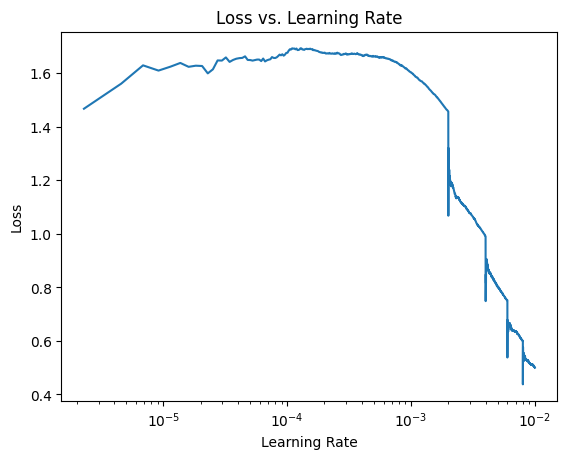

In [5]:
model.unfreeze()
model.lr_find(train_generator, validation_generator, epochs=5)

In [6]:
history_6_finetune = model.fit_epochs(train_generator, validation_generator, epochs=30, checkpoint_path=model_dir, lr=[1e-4, 5e-2])
histories.append(history_6_finetune)

Epoch 1/30
875/875 [==============================] - ETA: 0s - loss: 0.4234 - accuracy: 0.8470
Epoch 1: val_loss improved from inf to 0.67281, saving model to models/best_model_iteration_6.h5
875/875 [==============================] - 364s 416ms/step - loss: 0.4234 - accuracy: 0.8470 - val_loss: 0.6728 - val_accuracy: 0.7564


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
875/875 [==============================] - ETA: 0s - loss: 0.3869 - accuracy: 0.8571
Epoch 2: val_loss did not improve from 0.67281
875/875 [==============================] - 307s 350ms/step - loss: 0.3869 - accuracy: 0.8571 - val_loss: 0.6995 - val_accuracy: 0.7622
Epoch 3/30
875/875 [==============================] - ETA: 0s - loss: 0.3313 - accuracy: 0.8806
Epoch 3: val_loss did not improve from 0.67281
875/875 [==============================] - 284s 325ms/step - loss: 0.3313 - accuracy: 0.8806 - val_loss: 0.8588 - val_accuracy: 0.7442
Epoch 4/30
875/875 [==============================] - ETA: 0s - loss: 0.2796 - accuracy: 0.8999
Epoch 4: val_loss did not improve from 0.67281
875/875 [==============================] - 284s 324ms/step - loss: 0.2796 - accuracy: 0.8999 - val_loss: 0.6781 - val_accuracy: 0.7870
Epoch 5/30
875/875 [==============================] - ETA: 0s - loss: 0.2520 - accuracy: 0.9074
Epoch 5: val_loss did not improve from 0.67281
875/875 [==============

['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6']
Balanced Accuracy: 0.6778198865978023
Accuracy on test set: 0.8194444179534912
F1 Score: 0.8205341081655777


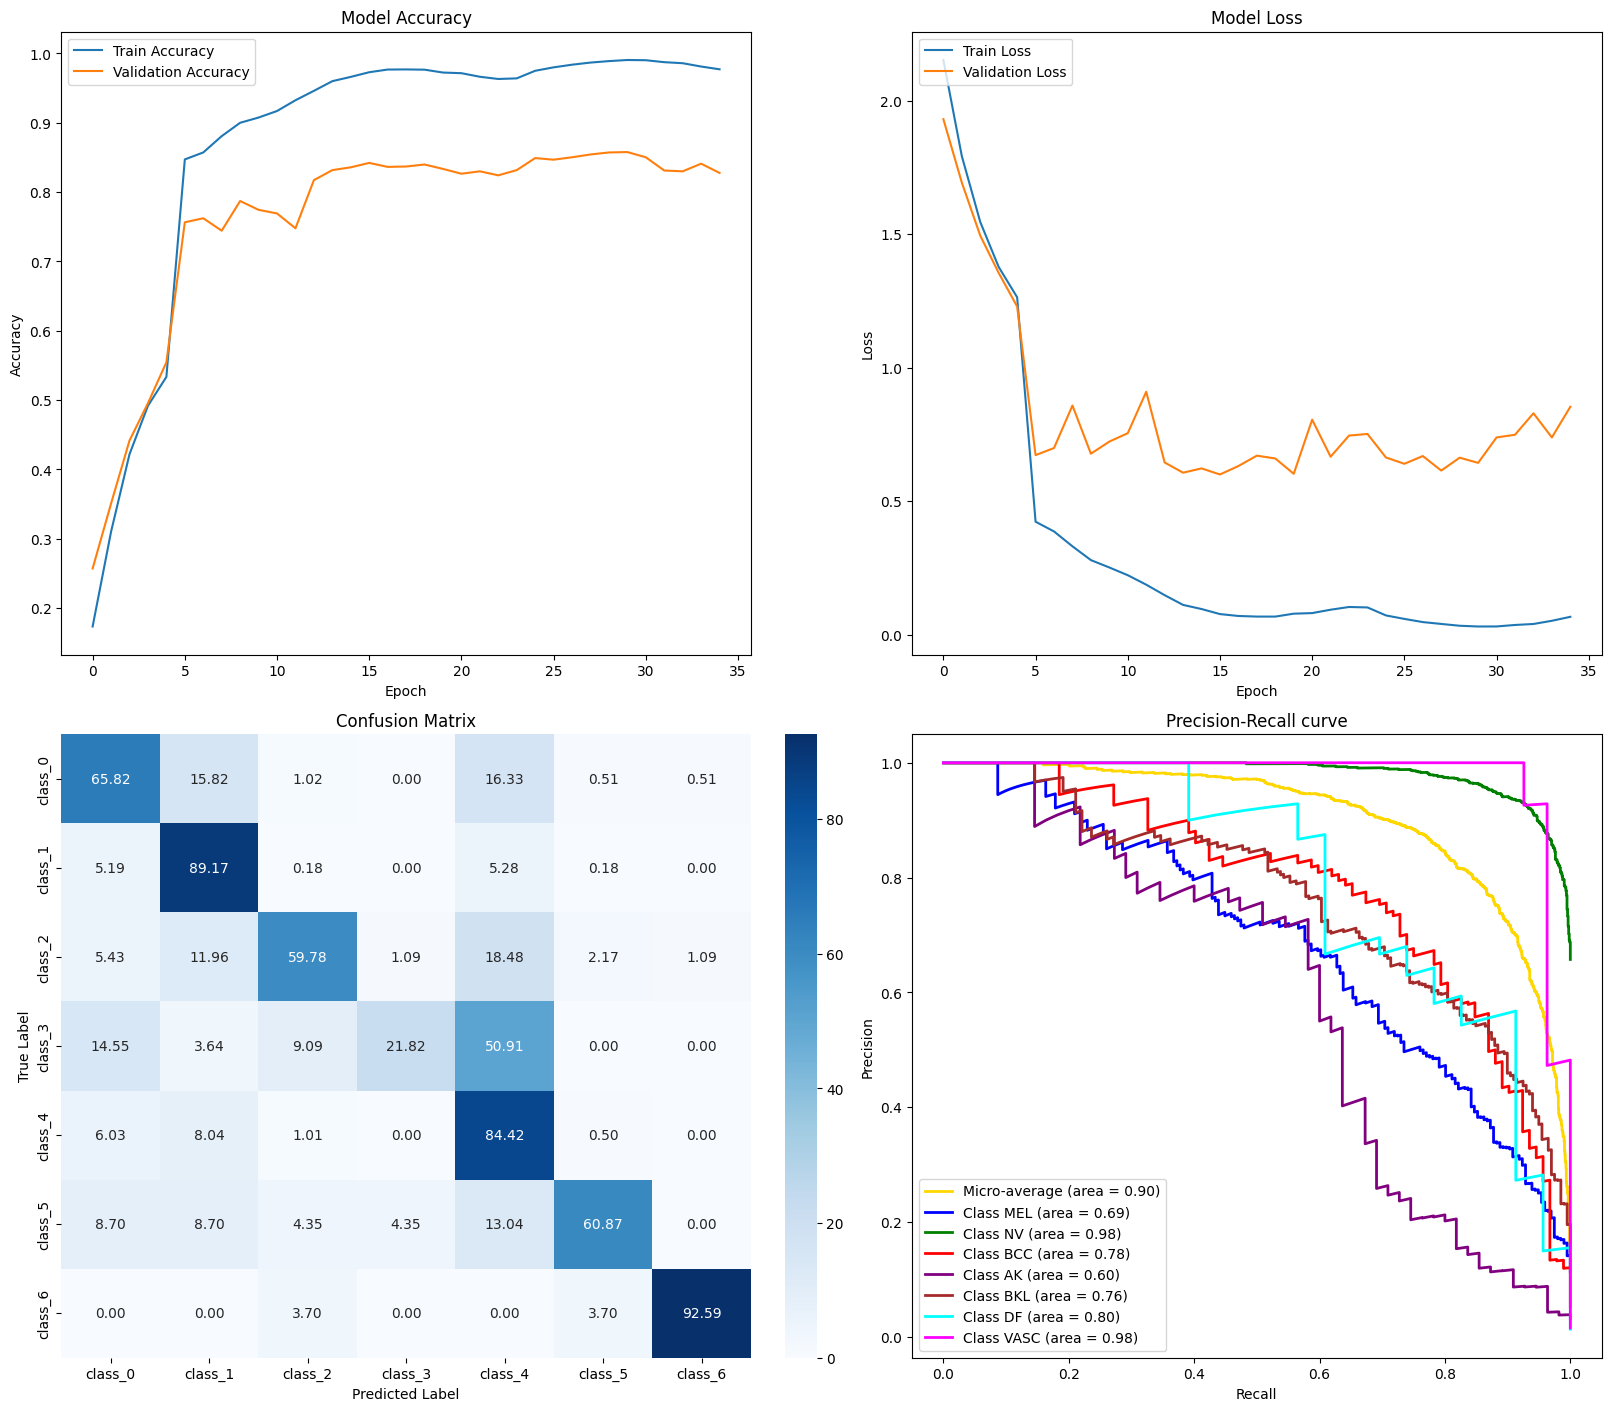

In [8]:
from tensorflow.keras.models import load_model
from plot_utils import show_all_plots
m = load_model(model_dir)
show_all_plots(histories, m, test_generator)